# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

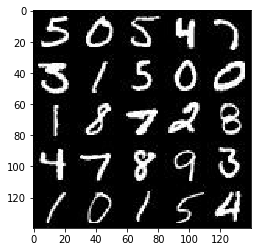

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

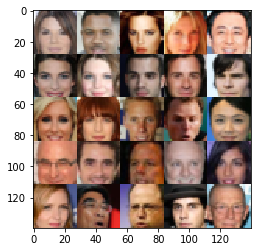

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image  = tf.placeholder(tf.float32,shape=[None,image_width,image_height,
                                                  image_channels],name = "real_image")
    input_z = tf.placeholder(tf.float32,[None,z_dim],name="input_z")
    
    learning_rate = tf.placeholder(tf.float32,name="learning_rate")

    return real_image, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.3
    with tf.variable_scope("discriminator",reuse=reuse):
        ## So our images are black and white so image shape would be
        ## [batch_size,28,28,1]
        #print(images.get_shape())
        x1=tf.layers.conv2d(images,filters=64,strides=2,kernel_size=5,padding="same",kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.layers.dropout(x1,0.5)
        ## output shape [14,14,64]
        #print(x1.get_shape())
        x2 = tf.layers.conv2d(x1,filters=128,strides=2,kernel_size=5,padding="same",use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(x2*alpha,x2)
        x2 = tf.layers.dropout(x2,0.5)
        #print(x2.get_shape())
        ##output shape [7,7,128]
        x3 = tf.layers.conv2d(x2,filters=256,kernel_size=5,strides =1 ,padding="same",use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.layers.dropout(x3,0.8)
        
        x3 = tf.layers.conv2d(x3,filters=256,kernel_size=5,strides =2 ,padding="same",use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.layers.dropout(x3,0.5)
        ## Output shape [2,2,256]
        #print(x3.get_shape())
        
        x4 = tf.layers.conv2d(x3,filters=512,strides=2,kernel_size=5,padding="same",use_bias=False,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4)
        x4 = tf.maximum(alpha*x4,x4)
        x4 = tf.layers.dropout(x4,0.8)
        #print(x4.get_shape())
        ## Output shape [1,1,512]
       #==============================================
        x4 = tf.layers.conv2d(x4,filters=1024,strides=1,kernel_size=5,padding="same",use_bias=False)
        x4 = tf.layers.batch_normalization(x4)
        x4 = tf.maximum(alpha*x4,x4)
        x4 = tf.layers.dropout(x4,0.8)
        ## added above layer
        
        #print(x4.get_shape())
        flatten_x4 = tf.reshape(x4,[-1,2*2*1024]) 
        logits = tf.contrib.layers.fully_connected(flatten_x4,1,activation_fn=None,
                                                  weights_initializer=tf.contrib.layers.xavier_initializer())
        logits = tf.layers.batch_normalization(logits)
        logits = tf.layers.dropout(logits,0.5) ##0.3
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    ## Basically in generator we don't need to reuse the variable so need to pass variable called 
    ## resues in function.
    alpha = 0
    with tf.variable_scope('generator',reuse= not is_train):
        x1 = tf.contrib.layers.fully_connected(z,512*4*4,activation_fn=None)
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        ## shape (BATCH_SIZE,512*4*4)
        
        ## Now reshaping it to [4,4,512]
        x2 = tf.reshape(x1,[-1,4,4,512]) ## -1 IS TO HANDEL THE BATCH SIZE
        
        ## Now reshaping it to [8,8,256]
        x2=tf.layers.conv2d_transpose(x2,filters=256,kernel_size=5,strides=2,padding="same",
                                    use_bias=False)
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        
        
        #Now reshaping it to [16,16,128]
        x3 = tf.layers.conv2d_transpose(x2,filters=128,kernel_size=5,strides=2,
                                       padding="same",use_bias=False)
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        
        
        x3 = tf.layers.conv2d_transpose(x3,filters=64,kernel_size=5,strides=2,
                                       padding="same",use_bias=False)
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        
        
        
        #x3 = tf.layers.conv2d_transpose(x3,filters=32,kernel_size=5,strides=2,
                                      # padding="same",use_bias=False)
        #x3 = tf.layers.batch_normalization(x3,training=is_train)
        #x3 = tf.maximum(alpha*x3,x3)
        
        ## Now reshaping it to [32,32,3]
        ## out_dims = 3 for color channels.
        x4 = tf.layers.conv2d_transpose(x3,filters=out_channel_dim,kernel_size=5,strides=2,
                                       padding="same",use_bias=False)

        
        
        
        # Output layer, 32x32x3
        logits = tf.image.resize_images(x4,(28,28))
        x4 = tf.tanh(logits)

    
    return x4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    ## Basically in generator we don't need to reuse the variable so need to pass variable called 
    ## resues in function.
    alpha = 0.0
    with tf.variable_scope('generator',reuse= not is_train):
        x1 = tf.contrib.layers.fully_connected(z,512*4*4,activation_fn=None,
                                               weights_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.layers.dropout(x1,0.7)
        ## shape (BATCH_SIZE,512*4*4)
        
        ## Now reshaping it to [4,4,512]
        x2 = tf.reshape(x1,[-1,4,4,512]) ## -1 IS TO HANDEL THE BATCH SIZE
        
        ## Now reshaping it to [8,8,256]
        x2=tf.layers.conv2d_transpose(x2,filters=256,kernel_size=5,strides=2,padding="same",
                                    use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        #x2 = tf.layers.dropout(x2,0.7)
        
        #Now reshaping it to [16,16,128]
        x3 = tf.layers.conv2d_transpose(x2,filters=128,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.layers.dropout(x3,0.7)
        
        # [32,32,62]
        x3 = tf.layers.conv2d_transpose(x3,filters=64,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        #x3 = tf.layers.dropout(x3,0.7)
        ## Now reshaping it to [32,32,3]
        ## out_dims = 3 for color channels.
        x4 = tf.layers.conv2d_transpose(x3,filters=out_channel_dim,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        
        # Output layer, 32x32x3
        logits = tf.image.resize_images(x4,(28,28))
        x5 = tf.tanh(logits)


    
    return x5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

In [66]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    ## Basically in generator we don't need to reuse the variable so need to pass variable called 
    ## resues in function.
    alpha = 0.2
    with tf.variable_scope('generator',reuse= not is_train):
        x1 = tf.contrib.layers.fully_connected(z,1024*2*2,activation_fn=None,
                                               weights_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha*x1,x1)
        x1 = tf.layers.dropout(x1,0.7)
        ## shape (BATCH_SIZE,512*4*4)
        
        ## Now reshaping it to [4,4,512]
        x2 = tf.reshape(x1,[-1,2,2,1024]) ## -1 IS TO HANDEL THE BATCH SIZE
        
        ## Now reshaping it to [8,8,256]
        x2=tf.layers.conv2d_transpose(x2,filters=512,kernel_size=5,strides=2,padding="same",
                                    use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)
        #print(x2.get_shape())
        #x2 = tf.layers.dropout(x2,0.7)
        
        #Now reshaping it to [16,16,128]
        x3 = tf.layers.conv2d_transpose(x2,filters=256,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        x3 = tf.layers.dropout(x3,0.7)
        #print(x3.get_shape())
        # [32,32,62]
        x3 = tf.layers.conv2d_transpose(x3,filters=128,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        #print(x3.get_shape())
        #x3 = tf.layers.dropout(x3,0.7)
        ## Now reshaping it to [32,32,3]
        ## out_dims = 3 for color channels.
        x3 = tf.layers.conv2d_transpose(x3,filters=64,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        #print(x3.get_shape())
        x4 = tf.layers.conv2d_transpose(x3,filters=out_channel_dim,kernel_size=5,strides=2,
                                       padding="same",use_bias=False,kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

        #print(x4.get_shape())
        # Output layer, 32x32x3
        logits = tf.image.resize_images(x4,(28,28))
        x5 = tf.tanh(logits)
        #print(x5.get_shape())


    
    return x5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [63]:
tf.reset_default_graph()

In [67]:
def model_loss(input_real, input_z,out_channel_dim ):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha=0.2
    output_dim = out_channel_dim
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
tests.test_model_loss(model_loss)

Tests Passed


In [15]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_out = generator(input_z, out_channel_dim=out_channel_dim)
    ## above generating fake image with generator network

    out,dis_gen_logit = discriminator(generator_out)
    ## then getting generator out form discriminator network by giving input `generator_out`.
    ## and respectively will keep labels as 1 or 0 according adversarial network training.
    dis_real_out,log_dis_real= discriminator(input_real,reuse=True)
    ## then getting discriminator output using discriminator network by using real images as input 
    ## and labels as 1.

    labels_gen_dis = tf.ones_like(dis_gen_logit)*np.random.choice([0.8,0.7,0.9])
    ## creating labels for generator training; here we want want network to classify fake image as 
    ## real and accroding train weights
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_gen_logit,labels=labels_gen_dis))
    ## now calculating loss and we will minimize this loss
    labels_dis_real = tf.ones_like(log_dis_real)*np.random.choice([0.8,0.7,0.9])
    ## creating labels for real images and want discriminator network to classify real images as 
    ## real.
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = log_dis_real,labels=labels_dis_real))
    ## caculating loss for real image
    labels_gen_fake = tf.zeros_like(dis_gen_logit)+np.random.choice([0.3,0.2,0.1])
    ## creating labels for generator input and this time want discriminator network to classify
    ## them as fake images and so we can make generator network to come up with better images
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_gen_logit,labels=labels_gen_fake))
    ## calculating loss for fake images
    d_loss = d_loss_fake+d_loss_real
    ## summation of loss of both real and fake and that is the LOSS of discriminator network.
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [68]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]


    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,
                                                                                    var_list=d_vars)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [69]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [70]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    ##Creating Placeholder
    real_image, input_z, learning_rate_ = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    ## data_shape[0] would be number of observation
    
    ## Creating model
    d_loss,g_loss = model_loss(input_real=real_image,input_z=input_z,out_channel_dim=data_shape[3])
    ## Creating optimizer
    d_opt, g_opt = model_opt(d_loss,g_loss,learning_rate_,beta1)
    #z = np.random.uniform(1,-1,[batch_size,z_dim])
    #print(z.shape)
    #print(data_shape)
    count = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_of_batch = data_shape[0]//batch_size
        print(num_of_batch)
        count_b =1
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #z = np.random.standard_normal(size=[batch_size,z_dim])
                #z = sess.run(tf.truncated_normal([batch_size,z_dim],stddev=1))
                _ = sess.run([d_opt],feed_dict={real_image:batch_images*2,
                                                   input_z:z,
                                                   learning_rate_:learning_rate})
                _ = sess.run([g_opt],feed_dict={real_image:batch_images*2,
                                                   input_z:z,
                                                   learning_rate_:learning_rate})
                
                g,d=sess.run([g_loss,d_loss],feed_dict={real_image:batch_images*2,
                                                   input_z:z,
                                                   learning_rate_:learning_rate})

                count_b+=1
                count+=1
                if count%50==0:
                    print("Epoch{}/{}....".format(epoch_i+1,epoch_count),
                          "Batch {}/{}..".format(count_b,num_of_batch),
                         "Discrimiator loss :{:.4f}..".format(d),
                          "Generator loss :{:.4f}..".format(g))
                if count%200==0:
                    show_generator_output(sess, n_images=30, input_z=input_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch1/2.... Discrimiator loss :1.3251.. Generator loss :0.7710..
Epoch1/2.... Discrimiator loss :1.4131.. Generator loss :0.7693..
Epoch1/2.... Discrimiator loss :1.3022.. Generator loss :0.7747..
Epoch1/2.... Discrimiator loss :1.4994.. Generator loss :0.6677..


Epoch1/2.... Discrimiator loss :1.2338.. Generator loss :1.5435..
Epoch1/2.... Discrimiator loss :1.2733.. Generator loss :0.8664..
Epoch1/2.... Discrimiator loss :1.0549.. Generator loss :0.9871..
Epoch1/2.... Discrimiator loss :1.2361.. Generator loss :0.8050..


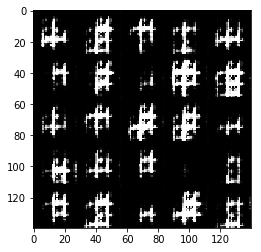

Epoch1/2.... Discrimiator loss :1.1152.. Generator loss :0.8657..
Epoch1/2.... Discrimiator loss :1.0188.. Generator loss :1.0470..
Epoch1/2.... Discrimiator loss :0.9906.. Generator loss :0.8470..
Epoch1/2.... Discrimiator loss :0.8715.. Generator loss :0.9397..


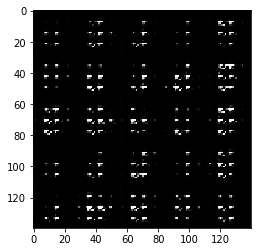

Epoch1/2.... Discrimiator loss :0.5340.. Generator loss :2.0848..
Epoch1/2.... Discrimiator loss :0.7217.. Generator loss :1.4635..
Epoch1/2.... Discrimiator loss :0.6563.. Generator loss :1.5521..
Epoch1/2.... Discrimiator loss :0.9694.. Generator loss :1.0085..


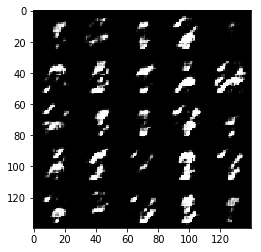

Epoch1/2.... Discrimiator loss :1.1730.. Generator loss :1.1414..
Epoch1/2.... Discrimiator loss :1.4208.. Generator loss :0.6379..
Epoch1/2.... Discrimiator loss :1.2271.. Generator loss :0.9544..
Epoch1/2.... Discrimiator loss :1.1390.. Generator loss :0.7464..


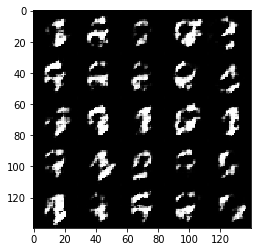

Epoch1/2.... Discrimiator loss :1.0007.. Generator loss :1.0464..
Epoch1/2.... Discrimiator loss :1.5505.. Generator loss :0.7037..
Epoch1/2.... Discrimiator loss :1.2435.. Generator loss :0.8255..
Epoch1/2.... Discrimiator loss :0.9241.. Generator loss :1.0480..


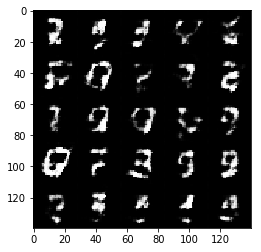

Epoch1/2.... Discrimiator loss :1.6198.. Generator loss :0.7002..
Epoch1/2.... Discrimiator loss :1.1439.. Generator loss :0.7347..
Epoch1/2.... Discrimiator loss :1.2094.. Generator loss :0.8744..
Epoch1/2.... Discrimiator loss :1.3075.. Generator loss :0.7909..


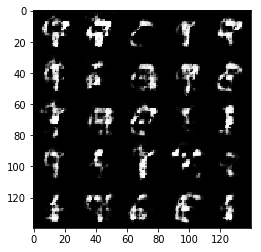

Epoch1/2.... Discrimiator loss :1.3791.. Generator loss :0.9135..
Epoch1/2.... Discrimiator loss :1.6630.. Generator loss :0.6629..
Epoch1/2.... Discrimiator loss :1.4800.. Generator loss :0.6777..
Epoch1/2.... Discrimiator loss :1.3414.. Generator loss :0.7756..


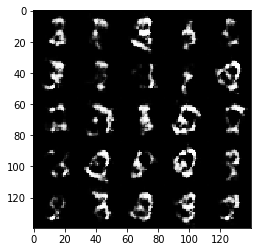

Epoch1/2.... Discrimiator loss :1.1131.. Generator loss :0.8521..
Epoch1/2.... Discrimiator loss :1.3238.. Generator loss :0.7614..
Epoch1/2.... Discrimiator loss :1.3468.. Generator loss :0.8787..
Epoch1/2.... Discrimiator loss :1.0383.. Generator loss :0.9952..


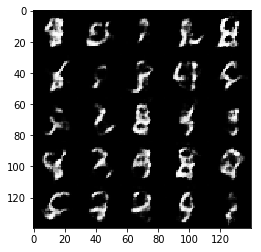

Epoch1/2.... Discrimiator loss :1.3386.. Generator loss :0.7593..
Epoch1/2.... Discrimiator loss :1.4762.. Generator loss :0.6427..
Epoch1/2.... Discrimiator loss :1.2278.. Generator loss :0.7830..
Epoch1/2.... Discrimiator loss :1.2846.. Generator loss :0.7929..


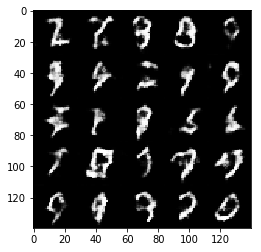

Epoch1/2.... Discrimiator loss :1.1038.. Generator loss :0.8822..
Epoch1/2.... Discrimiator loss :1.2893.. Generator loss :0.7969..
Epoch1/2.... Discrimiator loss :1.1134.. Generator loss :0.9646..
Epoch1/2.... Discrimiator loss :1.4411.. Generator loss :0.7219..


Epoch1/2.... Discrimiator loss :1.6229.. Generator loss :0.6510..
Epoch1/2.... Discrimiator loss :1.2916.. Generator loss :0.7551..
Epoch1/2.... Discrimiator loss :1.3053.. Generator loss :0.8106..
Epoch1/2.... Discrimiator loss :1.3033.. Generator loss :0.7995..


Epoch1/2.... Discrimiator loss :1.5415.. Generator loss :0.6902..
Epoch1/2.... Discrimiator loss :1.3595.. Generator loss :0.7625..
Epoch1/2.... Discrimiator loss :1.1740.. Generator loss :0.8465..
Epoch1/2.... Discrimiator loss :1.4425.. Generator loss :0.7623..


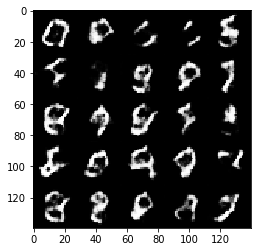

Epoch1/2.... Discrimiator loss :1.2072.. Generator loss :0.8117..
Epoch1/2.... Discrimiator loss :1.3923.. Generator loss :0.7310..
Epoch1/2.... Discrimiator loss :1.4475.. Generator loss :0.7543..
Epoch1/2.... Discrimiator loss :1.4247.. Generator loss :0.7717..


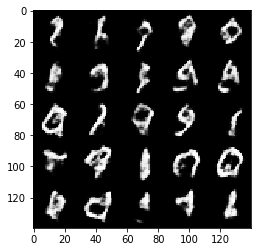

Epoch1/2.... Discrimiator loss :1.2128.. Generator loss :0.7875..
Epoch1/2.... Discrimiator loss :1.4411.. Generator loss :0.6513..
Epoch1/2.... Discrimiator loss :1.0803.. Generator loss :0.9935..
Epoch1/2.... Discrimiator loss :1.3364.. Generator loss :0.7186..


Epoch1/2.... Discrimiator loss :1.2515.. Generator loss :0.8042..
Epoch1/2.... Discrimiator loss :1.2472.. Generator loss :0.8943..
Epoch1/2.... Discrimiator loss :1.2890.. Generator loss :0.7227..
Epoch1/2.... Discrimiator loss :1.3169.. Generator loss :0.8168..


Epoch1/2.... Discrimiator loss :1.4274.. Generator loss :0.7388..
Epoch1/2.... Discrimiator loss :1.3071.. Generator loss :0.8296..
Epoch1/2.... Discrimiator loss :1.4249.. Generator loss :0.7041..
Epoch1/2.... Discrimiator loss :1.4686.. Generator loss :0.8291..


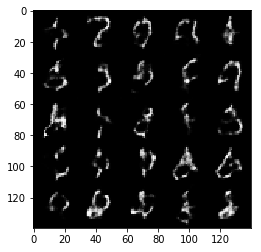

Epoch1/2.... Discrimiator loss :1.5114.. Generator loss :0.6930..
Epoch1/2.... Discrimiator loss :1.2959.. Generator loss :0.8366..
Epoch1/2.... Discrimiator loss :1.4484.. Generator loss :0.7683..
Epoch1/2.... Discrimiator loss :1.3105.. Generator loss :0.7835..


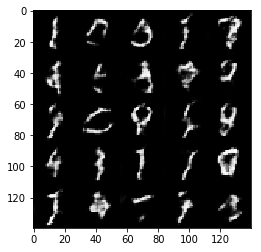

Epoch1/2.... Discrimiator loss :1.3415.. Generator loss :0.8002..
Epoch1/2.... Discrimiator loss :1.3258.. Generator loss :0.7627..
Epoch1/2.... Discrimiator loss :1.3267.. Generator loss :0.7610..
Epoch2/2.... Discrimiator loss :1.3758.. Generator loss :0.7614..


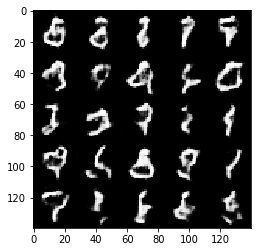

Epoch2/2.... Discrimiator loss :1.3801.. Generator loss :0.7852..
Epoch2/2.... Discrimiator loss :1.4339.. Generator loss :0.7055..
Epoch2/2.... Discrimiator loss :1.3631.. Generator loss :0.7260..
Epoch2/2.... Discrimiator loss :1.3106.. Generator loss :0.6554..


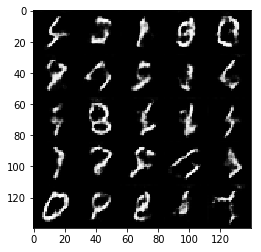

Epoch2/2.... Discrimiator loss :1.4285.. Generator loss :0.7142..
Epoch2/2.... Discrimiator loss :1.3153.. Generator loss :0.6972..
Epoch2/2.... Discrimiator loss :1.3101.. Generator loss :0.8228..
Epoch2/2.... Discrimiator loss :1.3331.. Generator loss :0.7773..


Epoch2/2.... Discrimiator loss :1.3435.. Generator loss :0.7888..
Epoch2/2.... Discrimiator loss :1.5004.. Generator loss :0.7159..
Epoch2/2.... Discrimiator loss :1.5412.. Generator loss :0.6300..
Epoch2/2.... Discrimiator loss :1.1967.. Generator loss :0.8854..


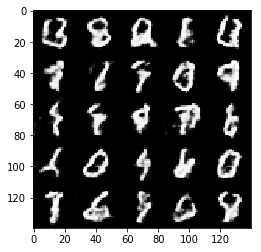

Epoch2/2.... Discrimiator loss :1.4530.. Generator loss :0.7380..
Epoch2/2.... Discrimiator loss :1.2222.. Generator loss :0.8074..
Epoch2/2.... Discrimiator loss :1.3056.. Generator loss :0.7693..
Epoch2/2.... Discrimiator loss :1.3768.. Generator loss :0.7604..


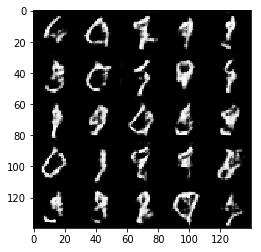

Epoch2/2.... Discrimiator loss :1.5317.. Generator loss :0.9139..
Epoch2/2.... Discrimiator loss :1.2983.. Generator loss :0.7010..
Epoch2/2.... Discrimiator loss :1.3859.. Generator loss :0.7797..
Epoch2/2.... Discrimiator loss :1.3001.. Generator loss :0.7870..


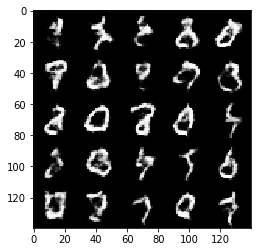

Epoch2/2.... Discrimiator loss :1.4782.. Generator loss :0.6937..
Epoch2/2.... Discrimiator loss :1.5920.. Generator loss :0.6666..
Epoch2/2.... Discrimiator loss :1.2436.. Generator loss :0.8519..
Epoch2/2.... Discrimiator loss :1.2746.. Generator loss :0.8012..


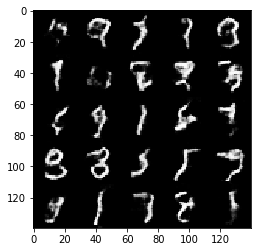

Epoch2/2.... Discrimiator loss :1.4726.. Generator loss :0.7399..
Epoch2/2.... Discrimiator loss :1.3867.. Generator loss :0.7497..
Epoch2/2.... Discrimiator loss :1.2637.. Generator loss :0.7976..
Epoch2/2.... Discrimiator loss :1.2308.. Generator loss :0.8702..


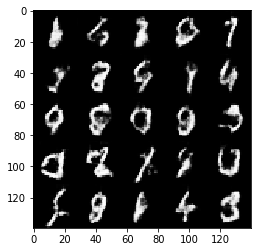

Epoch2/2.... Discrimiator loss :1.4576.. Generator loss :0.7172..
Epoch2/2.... Discrimiator loss :1.4548.. Generator loss :0.7542..
Epoch2/2.... Discrimiator loss :1.4215.. Generator loss :0.7476..
Epoch2/2.... Discrimiator loss :1.4265.. Generator loss :0.7161..


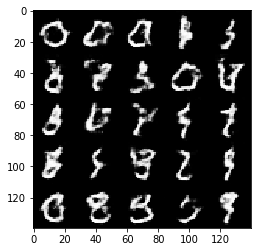

Epoch2/2.... Discrimiator loss :1.2951.. Generator loss :0.8102..
Epoch2/2.... Discrimiator loss :1.3293.. Generator loss :0.7716..
Epoch2/2.... Discrimiator loss :1.3834.. Generator loss :0.7773..
Epoch2/2.... Discrimiator loss :1.4038.. Generator loss :0.6896..


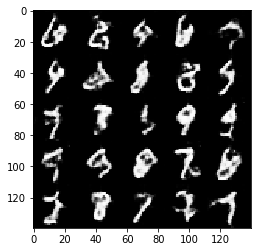

Epoch2/2.... Discrimiator loss :1.2180.. Generator loss :0.8033..
Epoch2/2.... Discrimiator loss :1.3340.. Generator loss :0.7836..
Epoch2/2.... Discrimiator loss :1.3378.. Generator loss :0.7901..
Epoch2/2.... Discrimiator loss :1.4146.. Generator loss :1.2884..


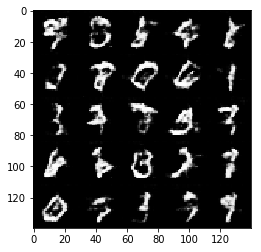

Epoch2/2.... Discrimiator loss :1.2905.. Generator loss :0.7939..
Epoch2/2.... Discrimiator loss :1.3270.. Generator loss :0.8000..
Epoch2/2.... Discrimiator loss :1.2878.. Generator loss :0.7847..
Epoch2/2.... Discrimiator loss :1.3860.. Generator loss :0.7968..


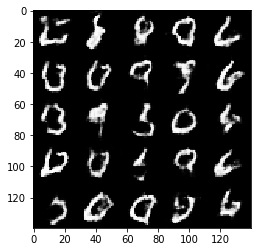

Epoch2/2.... Discrimiator loss :1.4805.. Generator loss :0.6580..
Epoch2/2.... Discrimiator loss :1.1162.. Generator loss :0.8525..
Epoch2/2.... Discrimiator loss :1.3250.. Generator loss :0.8217..
Epoch2/2.... Discrimiator loss :1.4008.. Generator loss :0.7151..


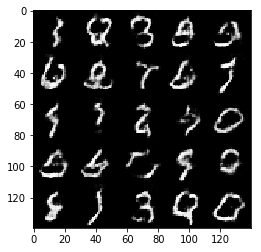

Epoch2/2.... Discrimiator loss :1.4265.. Generator loss :0.9298..
Epoch2/2.... Discrimiator loss :1.2376.. Generator loss :0.9449..
Epoch2/2.... Discrimiator loss :1.3689.. Generator loss :0.7075..
Epoch2/2.... Discrimiator loss :1.3362.. Generator loss :0.7845..


Epoch2/2.... Discrimiator loss :1.4395.. Generator loss :0.7628..
Epoch2/2.... Discrimiator loss :1.3517.. Generator loss :0.7911..
Epoch2/2.... Discrimiator loss :1.3589.. Generator loss :0.8098..
Epoch2/2.... Discrimiator loss :1.3562.. Generator loss :0.7946..


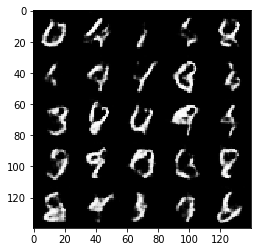

Epoch2/2.... Discrimiator loss :1.1958.. Generator loss :0.8684..
Epoch2/2.... Discrimiator loss :1.2512.. Generator loss :0.7371..
Epoch2/2.... Discrimiator loss :1.4771.. Generator loss :0.7944..
Epoch2/2.... Discrimiator loss :1.2255.. Generator loss :0.8485..


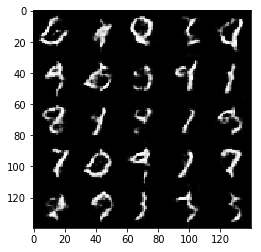

Epoch2/2.... Discrimiator loss :1.2148.. Generator loss :0.8852..
Epoch2/2.... Discrimiator loss :1.4897.. Generator loss :0.6845..
Epoch2/2.... Discrimiator loss :1.5193.. Generator loss :0.6529..
Epoch2/2.... Discrimiator loss :1.4194.. Generator loss :0.7118..


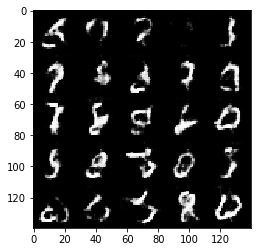

Epoch2/2.... Discrimiator loss :1.2097.. Generator loss :0.8012..
Epoch2/2.... Discrimiator loss :1.4983.. Generator loss :0.7116..
Epoch2/2.... Discrimiator loss :1.2763.. Generator loss :0.7805..
Epoch2/2.... Discrimiator loss :1.4145.. Generator loss :0.7413..


Epoch2/2.... Discrimiator loss :1.3945.. Generator loss :0.7253..
Epoch2/2.... Discrimiator loss :1.3365.. Generator loss :0.7400..
Epoch2/2.... Discrimiator loss :1.2781.. Generator loss :0.8617..
Epoch2/2.... Discrimiator loss :1.3561.. Generator loss :0.8817..


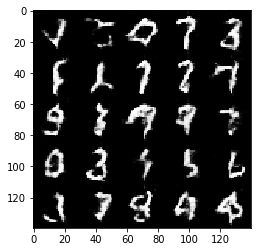

Epoch2/2.... Discrimiator loss :1.3220.. Generator loss :0.7550..
Epoch2/2.... Discrimiator loss :1.5805.. Generator loss :0.6737..


In [19]:
batch_size = 16
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch1/2.... Discrimiator loss :0.7605.. Generator loss :1.2127..
Epoch1/2.... Discrimiator loss :1.3785.. Generator loss :0.6772..
Epoch1/2.... Discrimiator loss :1.2839.. Generator loss :1.8528..
Epoch1/2.... Discrimiator loss :1.1998.. Generator loss :0.7408..


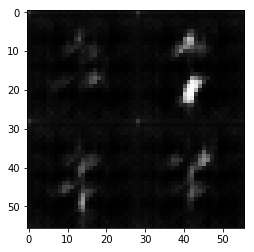

Epoch1/2.... Discrimiator loss :1.2535.. Generator loss :0.7813..
Epoch1/2.... Discrimiator loss :1.1949.. Generator loss :1.0014..
Epoch1/2.... Discrimiator loss :1.0536.. Generator loss :0.8965..
Epoch1/2.... Discrimiator loss :1.1459.. Generator loss :1.4081..


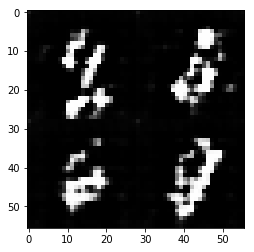

Epoch1/2.... Discrimiator loss :1.0139.. Generator loss :1.1423..
Epoch1/2.... Discrimiator loss :1.2069.. Generator loss :1.3104..
Epoch1/2.... Discrimiator loss :1.0192.. Generator loss :1.0898..
Epoch1/2.... Discrimiator loss :1.0473.. Generator loss :1.2227..


Epoch1/2.... Discrimiator loss :1.0761.. Generator loss :0.9774..
Epoch1/2.... Discrimiator loss :1.1327.. Generator loss :0.8671..
Epoch1/2.... Discrimiator loss :1.2109.. Generator loss :0.9387..
Epoch1/2.... Discrimiator loss :1.2951.. Generator loss :0.7990..


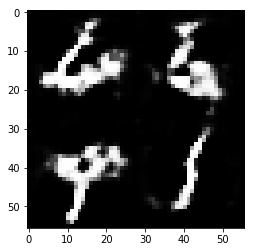

Epoch1/2.... Discrimiator loss :1.4640.. Generator loss :0.5577..
Epoch1/2.... Discrimiator loss :1.2006.. Generator loss :1.1899..
Epoch1/2.... Discrimiator loss :1.3893.. Generator loss :0.6277..
Epoch1/2.... Discrimiator loss :1.1291.. Generator loss :1.0303..


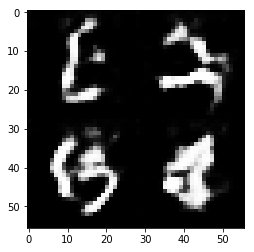

Epoch1/2.... Discrimiator loss :1.2389.. Generator loss :0.8730..
Epoch1/2.... Discrimiator loss :1.2410.. Generator loss :1.0284..
Epoch1/2.... Discrimiator loss :1.2808.. Generator loss :0.7935..
Epoch1/2.... Discrimiator loss :1.2191.. Generator loss :0.9997..


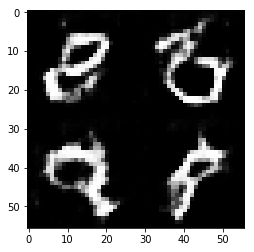

Epoch2/2.... Discrimiator loss :1.2719.. Generator loss :0.8964..
Epoch2/2.... Discrimiator loss :1.2170.. Generator loss :0.8815..
Epoch2/2.... Discrimiator loss :1.1598.. Generator loss :0.9519..
Epoch2/2.... Discrimiator loss :1.3069.. Generator loss :0.7013..


Epoch2/2.... Discrimiator loss :1.2166.. Generator loss :1.0572..
Epoch2/2.... Discrimiator loss :1.1921.. Generator loss :0.8886..
Epoch2/2.... Discrimiator loss :1.2614.. Generator loss :0.8732..
Epoch2/2.... Discrimiator loss :1.1740.. Generator loss :0.9363..


Epoch2/2.... Discrimiator loss :1.1570.. Generator loss :0.9418..
Epoch2/2.... Discrimiator loss :1.2497.. Generator loss :1.0971..
Epoch2/2.... Discrimiator loss :1.1169.. Generator loss :1.0057..
Epoch2/2.... Discrimiator loss :1.1761.. Generator loss :0.9126..


Epoch2/2.... Discrimiator loss :1.2070.. Generator loss :0.8314..
Epoch2/2.... Discrimiator loss :1.1884.. Generator loss :1.0819..
Epoch2/2.... Discrimiator loss :1.2682.. Generator loss :0.9700..
Epoch2/2.... Discrimiator loss :1.2666.. Generator loss :0.7849..


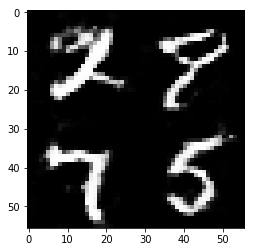

Epoch2/2.... Discrimiator loss :1.1860.. Generator loss :0.8194..
Epoch2/2.... Discrimiator loss :1.3368.. Generator loss :0.8189..
Epoch2/2.... Discrimiator loss :1.2701.. Generator loss :0.8374..
Epoch2/2.... Discrimiator loss :1.2265.. Generator loss :0.9625..


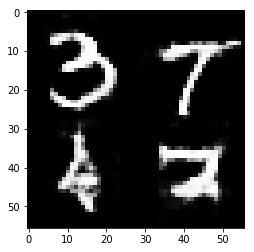

Epoch2/2.... Discrimiator loss :1.2129.. Generator loss :0.8431..
Epoch2/2.... Discrimiator loss :1.2832.. Generator loss :0.8948..
Epoch2/2.... Discrimiator loss :1.2228.. Generator loss :0.9050..
Epoch2/2.... Discrimiator loss :1.2914.. Generator loss :0.8264..


In [35]:
batch_size = 50
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch1/2.... Discrimiator loss :1.0116.. Generator loss :1.2338..
Epoch1/2.... Discrimiator loss :1.1667.. Generator loss :0.9133..
Epoch1/2.... Discrimiator loss :0.9353.. Generator loss :0.9400..
Epoch1/2.... Discrimiator loss :0.7750.. Generator loss :1.3538..


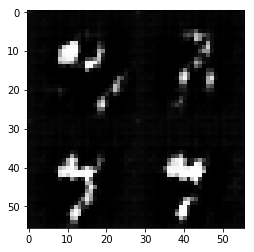

Epoch1/2.... Discrimiator loss :1.3910.. Generator loss :2.5204..
Epoch1/2.... Discrimiator loss :1.0818.. Generator loss :1.0848..
Epoch1/2.... Discrimiator loss :0.8766.. Generator loss :1.7756..
Epoch1/2.... Discrimiator loss :1.1921.. Generator loss :0.9084..


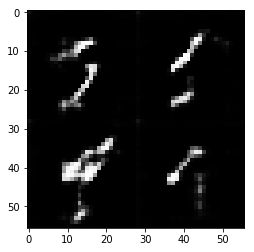

Epoch1/2.... Discrimiator loss :1.0335.. Generator loss :1.3694..
Epoch1/2.... Discrimiator loss :0.9708.. Generator loss :1.3690..
Epoch1/2.... Discrimiator loss :1.0237.. Generator loss :1.0823..
Epoch1/2.... Discrimiator loss :1.1825.. Generator loss :0.9163..


Epoch1/2.... Discrimiator loss :1.0669.. Generator loss :1.0754..
Epoch1/2.... Discrimiator loss :1.1720.. Generator loss :1.0187..
Epoch1/2.... Discrimiator loss :1.1189.. Generator loss :1.2347..
Epoch1/2.... Discrimiator loss :1.1745.. Generator loss :0.8842..


Epoch1/2.... Discrimiator loss :1.0067.. Generator loss :0.9987..
Epoch1/2.... Discrimiator loss :1.0573.. Generator loss :1.2571..
Epoch1/2.... Discrimiator loss :1.1673.. Generator loss :1.0028..
Epoch1/2.... Discrimiator loss :1.2043.. Generator loss :0.8362..


Epoch1/2.... Discrimiator loss :1.1389.. Generator loss :1.0010..
Epoch1/2.... Discrimiator loss :1.0494.. Generator loss :1.0936..
Epoch1/2.... Discrimiator loss :1.1079.. Generator loss :1.1274..
Epoch1/2.... Discrimiator loss :1.2459.. Generator loss :1.0569..


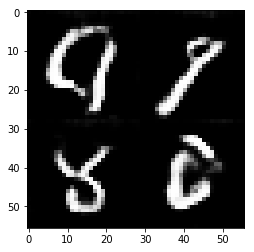

Epoch1/2.... Discrimiator loss :1.2122.. Generator loss :0.8637..
Epoch1/2.... Discrimiator loss :1.3123.. Generator loss :0.7677..
Epoch1/2.... Discrimiator loss :1.1463.. Generator loss :0.8607..
Epoch1/2.... Discrimiator loss :1.1210.. Generator loss :0.9424..


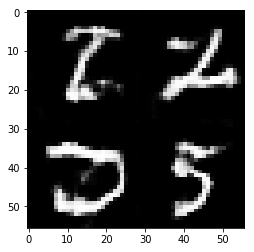

Epoch1/2.... Discrimiator loss :1.2310.. Generator loss :0.8644..
Epoch1/2.... Discrimiator loss :1.0718.. Generator loss :1.0743..
Epoch1/2.... Discrimiator loss :1.1434.. Generator loss :0.8120..
Epoch1/2.... Discrimiator loss :1.2458.. Generator loss :0.7514..


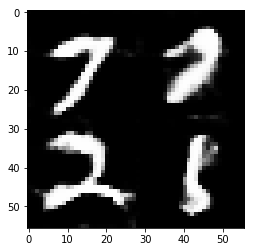

Epoch1/2.... Discrimiator loss :1.1318.. Generator loss :0.9524..
Epoch1/2.... Discrimiator loss :1.1840.. Generator loss :0.8574..
Epoch1/2.... Discrimiator loss :1.1339.. Generator loss :0.9857..
Epoch1/2.... Discrimiator loss :1.2419.. Generator loss :0.8986..


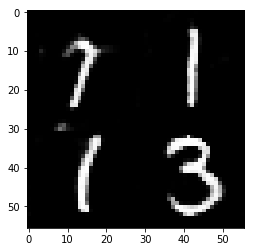

Epoch1/2.... Discrimiator loss :1.2196.. Generator loss :0.8234..
Epoch2/2.... Discrimiator loss :1.1852.. Generator loss :0.9098..
Epoch2/2.... Discrimiator loss :1.1006.. Generator loss :0.8367..
Epoch2/2.... Discrimiator loss :1.1629.. Generator loss :1.1554..


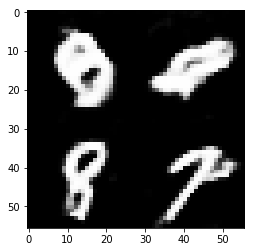

Epoch2/2.... Discrimiator loss :1.1514.. Generator loss :0.9428..
Epoch2/2.... Discrimiator loss :1.1550.. Generator loss :0.9931..
Epoch2/2.... Discrimiator loss :1.1505.. Generator loss :1.0470..
Epoch2/2.... Discrimiator loss :1.2934.. Generator loss :0.7980..


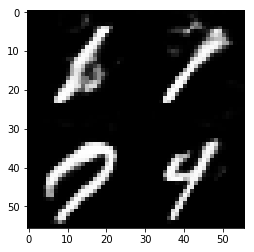

Epoch2/2.... Discrimiator loss :1.1913.. Generator loss :0.7948..
Epoch2/2.... Discrimiator loss :1.0783.. Generator loss :1.0546..
Epoch2/2.... Discrimiator loss :1.1809.. Generator loss :0.8878..
Epoch2/2.... Discrimiator loss :1.1973.. Generator loss :0.8455..


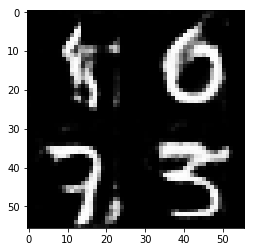

Epoch2/2.... Discrimiator loss :1.1193.. Generator loss :0.9143..
Epoch2/2.... Discrimiator loss :1.2330.. Generator loss :0.9713..
Epoch2/2.... Discrimiator loss :1.2237.. Generator loss :0.8242..
Epoch2/2.... Discrimiator loss :1.2747.. Generator loss :0.7974..


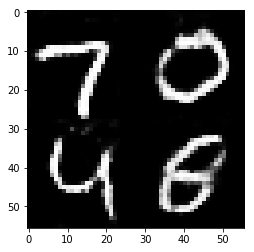

Epoch2/2.... Discrimiator loss :1.1876.. Generator loss :0.8900..
Epoch2/2.... Discrimiator loss :1.3675.. Generator loss :0.7945..
Epoch2/2.... Discrimiator loss :1.2865.. Generator loss :0.9014..
Epoch2/2.... Discrimiator loss :1.1748.. Generator loss :1.1011..


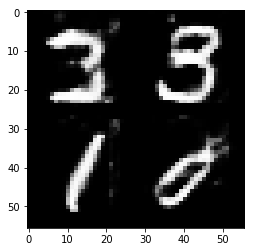

Epoch2/2.... Discrimiator loss :1.1837.. Generator loss :0.9013..
Epoch2/2.... Discrimiator loss :1.3734.. Generator loss :0.7418..
Epoch2/2.... Discrimiator loss :1.2748.. Generator loss :0.8520..
Epoch2/2.... Discrimiator loss :1.4281.. Generator loss :0.6967..


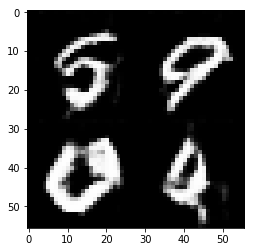

Epoch2/2.... Discrimiator loss :1.1837.. Generator loss :0.8402..
Epoch2/2.... Discrimiator loss :1.2970.. Generator loss :0.7788..
Epoch2/2.... Discrimiator loss :1.3186.. Generator loss :0.9733..
Epoch2/2.... Discrimiator loss :1.2808.. Generator loss :0.8746..


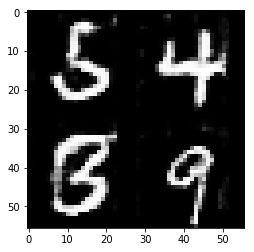

Epoch2/2.... Discrimiator loss :1.2509.. Generator loss :0.8031..
Epoch2/2.... Discrimiator loss :1.2409.. Generator loss :0.8482..
Epoch2/2.... Discrimiator loss :1.2151.. Generator loss :0.7941..
Epoch2/2.... Discrimiator loss :1.2811.. Generator loss :0.7817..


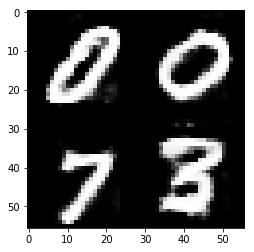

Epoch2/2.... Discrimiator loss :1.2799.. Generator loss :0.8838..
Epoch2/2.... Discrimiator loss :1.3148.. Generator loss :0.8030..
Epoch2/2.... Discrimiator loss :1.2841.. Generator loss :0.8372..
Epoch2/2.... Discrimiator loss :1.2289.. Generator loss :0.7900..


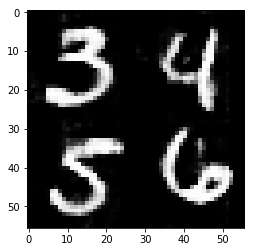

Epoch2/2.... Discrimiator loss :1.2311.. Generator loss :0.8185..
Epoch2/2.... Discrimiator loss :1.2902.. Generator loss :0.8061..
Epoch2/2.... Discrimiator loss :1.2424.. Generator loss :0.7798..


In [36]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch1/2.... Discrimiator loss :1.3703.. Generator loss :0.7414..
Epoch1/2.... Discrimiator loss :1.6037.. Generator loss :1.2204..
Epoch1/2.... Discrimiator loss :1.3799.. Generator loss :0.7604..
Epoch1/2.... Discrimiator loss :1.3276.. Generator loss :0.7341..


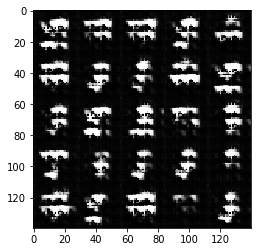

Epoch1/2.... Discrimiator loss :1.1966.. Generator loss :0.8667..
Epoch1/2.... Discrimiator loss :1.3472.. Generator loss :0.8299..
Epoch1/2.... Discrimiator loss :1.2570.. Generator loss :0.6708..
Epoch1/2.... Discrimiator loss :1.2337.. Generator loss :0.8777..


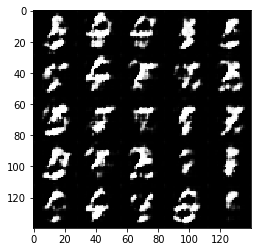

Epoch1/2.... Discrimiator loss :1.1807.. Generator loss :0.8581..
Epoch2/2.... Discrimiator loss :1.1044.. Generator loss :0.9804..
Epoch2/2.... Discrimiator loss :1.2489.. Generator loss :0.9210..
Epoch2/2.... Discrimiator loss :1.3826.. Generator loss :0.9261..


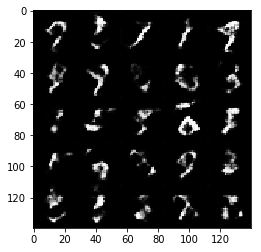

Epoch2/2.... Discrimiator loss :1.2025.. Generator loss :0.8715..
Epoch2/2.... Discrimiator loss :1.2454.. Generator loss :0.7602..
Epoch2/2.... Discrimiator loss :1.3072.. Generator loss :0.8188..
Epoch2/2.... Discrimiator loss :1.2563.. Generator loss :0.7928..


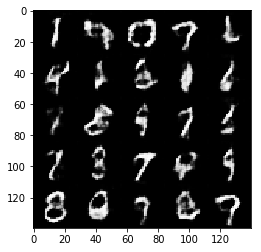

Epoch2/2.... Discrimiator loss :1.4482.. Generator loss :0.7431..
Epoch2/2.... Discrimiator loss :1.3347.. Generator loss :0.7864..


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.001

beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch1/1.... Discrimiator loss :0.8675.. Generator loss :1.0062..
Epoch1/1.... Discrimiator loss :1.2293.. Generator loss :0.8711..
Epoch1/1.... Discrimiator loss :1.3211.. Generator loss :0.8072..
Epoch1/1.... Discrimiator loss :1.7408.. Generator loss :0.6831..


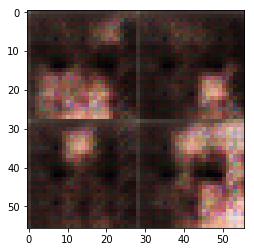

Epoch1/1.... Discrimiator loss :1.2887.. Generator loss :0.8631..
Epoch1/1.... Discrimiator loss :1.2034.. Generator loss :0.7567..
Epoch1/1.... Discrimiator loss :1.1588.. Generator loss :0.9117..
Epoch1/1.... Discrimiator loss :1.0949.. Generator loss :0.9727..


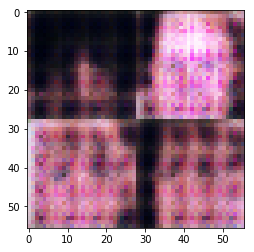

Epoch1/1.... Discrimiator loss :1.2756.. Generator loss :0.8294..
Epoch1/1.... Discrimiator loss :1.0298.. Generator loss :0.9396..
Epoch1/1.... Discrimiator loss :1.2717.. Generator loss :0.7809..
Epoch1/1.... Discrimiator loss :1.2447.. Generator loss :0.7462..


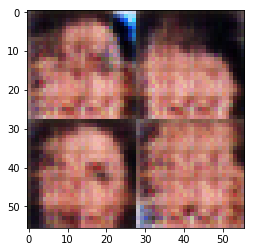

Epoch1/1.... Discrimiator loss :1.0548.. Generator loss :0.8614..
Epoch1/1.... Discrimiator loss :2.5831.. Generator loss :2.4962..
Epoch1/1.... Discrimiator loss :1.3039.. Generator loss :0.7653..
Epoch1/1.... Discrimiator loss :1.2675.. Generator loss :0.8907..


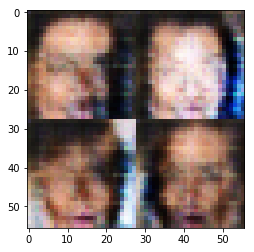

Epoch1/1.... Discrimiator loss :1.1617.. Generator loss :0.8876..
Epoch1/1.... Discrimiator loss :1.2417.. Generator loss :1.0449..
Epoch1/1.... Discrimiator loss :1.3193.. Generator loss :0.8582..
Epoch1/1.... Discrimiator loss :1.2238.. Generator loss :0.9185..


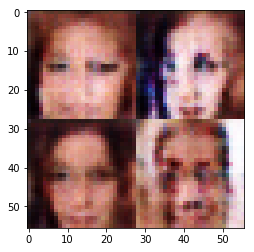

Epoch1/1.... Discrimiator loss :1.2262.. Generator loss :0.8528..
Epoch1/1.... Discrimiator loss :1.2243.. Generator loss :0.8419..
Epoch1/1.... Discrimiator loss :1.3747.. Generator loss :0.7146..
Epoch1/1.... Discrimiator loss :1.1305.. Generator loss :0.9448..


Epoch1/1.... Discrimiator loss :1.2271.. Generator loss :0.8624..
Epoch1/1.... Discrimiator loss :1.2814.. Generator loss :0.8722..
Epoch1/1.... Discrimiator loss :1.3243.. Generator loss :0.7111..
Epoch1/1.... Discrimiator loss :1.1035.. Generator loss :0.9916..


Epoch1/1.... Discrimiator loss :1.2356.. Generator loss :0.8054..
Epoch1/1.... Discrimiator loss :1.0748.. Generator loss :1.0220..
Epoch1/1.... Discrimiator loss :1.3909.. Generator loss :0.9653..
Epoch1/1.... Discrimiator loss :1.4601.. Generator loss :0.7191..


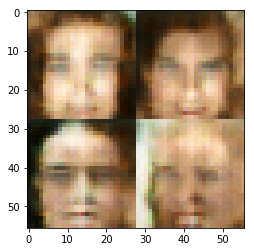

Epoch1/1.... Discrimiator loss :1.2631.. Generator loss :0.7606..
Epoch1/1.... Discrimiator loss :1.3032.. Generator loss :0.7774..
Epoch1/1.... Discrimiator loss :1.3290.. Generator loss :0.8035..
Epoch1/1.... Discrimiator loss :1.0627.. Generator loss :0.9278..


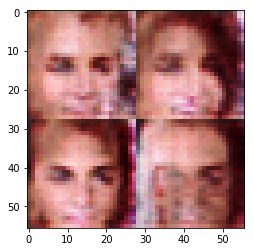

Epoch1/1.... Discrimiator loss :1.3544.. Generator loss :0.8242..
Epoch1/1.... Discrimiator loss :1.2156.. Generator loss :0.9012..
Epoch1/1.... Discrimiator loss :1.4577.. Generator loss :0.7414..
Epoch1/1.... Discrimiator loss :1.3495.. Generator loss :0.8001..


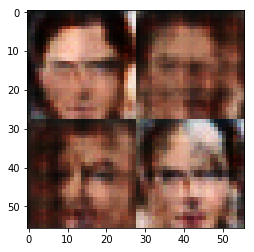

Epoch1/1.... Discrimiator loss :1.2432.. Generator loss :0.8038..
Epoch1/1.... Discrimiator loss :1.1850.. Generator loss :0.8959..
Epoch1/1.... Discrimiator loss :1.1635.. Generator loss :0.8959..
Epoch1/1.... Discrimiator loss :1.5051.. Generator loss :0.6380..


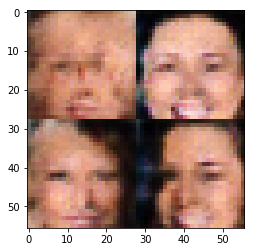

Epoch1/1.... Discrimiator loss :1.5590.. Generator loss :0.6320..
Epoch1/1.... Discrimiator loss :1.4945.. Generator loss :0.7263..
Epoch1/1.... Discrimiator loss :1.3476.. Generator loss :0.8736..
Epoch1/1.... Discrimiator loss :1.3460.. Generator loss :0.9865..


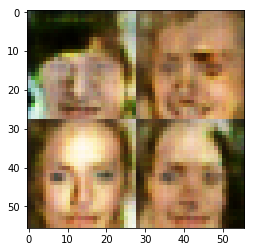

Epoch1/1.... Discrimiator loss :1.3294.. Generator loss :0.8039..
Epoch1/1.... Discrimiator loss :1.4210.. Generator loss :0.6356..
Epoch1/1.... Discrimiator loss :1.1863.. Generator loss :0.9324..
Epoch1/1.... Discrimiator loss :1.3768.. Generator loss :0.8678..


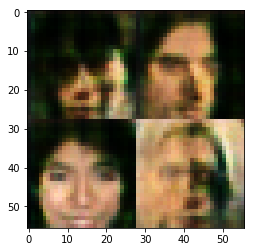

Epoch1/1.... Discrimiator loss :1.3461.. Generator loss :0.8103..
Epoch1/1.... Discrimiator loss :1.1144.. Generator loss :0.8298..
Epoch1/1.... Discrimiator loss :1.4057.. Generator loss :0.7946..
Epoch1/1.... Discrimiator loss :1.3379.. Generator loss :0.8711..


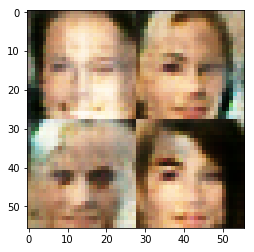

Epoch1/1.... Discrimiator loss :1.2789.. Generator loss :0.7527..
Epoch1/1.... Discrimiator loss :1.3357.. Generator loss :0.7509..
Epoch1/1.... Discrimiator loss :1.2733.. Generator loss :0.7998..
Epoch1/1.... Discrimiator loss :1.3307.. Generator loss :0.6974..


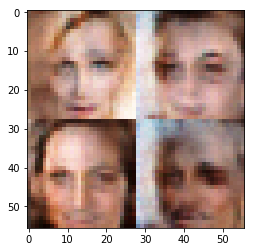

Epoch1/1.... Discrimiator loss :1.3370.. Generator loss :0.8267..
Epoch1/1.... Discrimiator loss :1.1186.. Generator loss :0.9087..
Epoch1/1.... Discrimiator loss :1.2658.. Generator loss :0.7776..
Epoch1/1.... Discrimiator loss :1.3038.. Generator loss :0.8437..


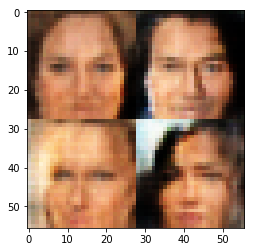

Epoch1/1.... Discrimiator loss :1.2602.. Generator loss :0.8247..
Epoch1/1.... Discrimiator loss :1.2913.. Generator loss :0.8180..
Epoch1/1.... Discrimiator loss :1.2551.. Generator loss :0.8187..
Epoch1/1.... Discrimiator loss :1.3585.. Generator loss :0.7332..


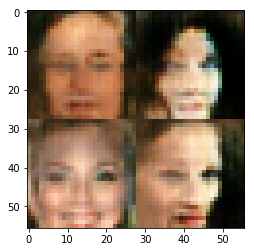

Epoch1/1.... Discrimiator loss :1.2354.. Generator loss :0.9022..
Epoch1/1.... Discrimiator loss :1.2328.. Generator loss :0.8764..
Epoch1/1.... Discrimiator loss :1.2724.. Generator loss :0.8645..
Epoch1/1.... Discrimiator loss :1.2454.. Generator loss :0.8173..


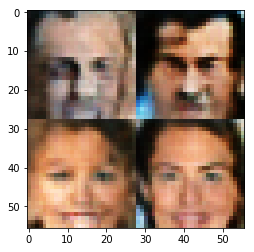

Epoch1/1.... Discrimiator loss :1.2688.. Generator loss :0.8279..
Epoch1/1.... Discrimiator loss :1.3195.. Generator loss :0.8179..
Epoch1/1.... Discrimiator loss :1.2489.. Generator loss :0.9650..
Epoch1/1.... Discrimiator loss :1.1972.. Generator loss :0.8422..


Epoch1/1.... Discrimiator loss :1.3284.. Generator loss :0.7389..
Epoch1/1.... Discrimiator loss :1.2772.. Generator loss :0.8830..
Epoch1/1.... Discrimiator loss :1.2490.. Generator loss :0.7852..
Epoch1/1.... Discrimiator loss :1.2864.. Generator loss :0.8570..


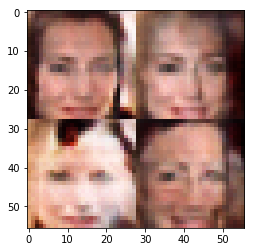

Epoch1/1.... Discrimiator loss :1.1796.. Generator loss :0.8084..
Epoch1/1.... Discrimiator loss :1.2602.. Generator loss :0.8187..
Epoch1/1.... Discrimiator loss :1.4458.. Generator loss :0.7062..
Epoch1/1.... Discrimiator loss :1.2995.. Generator loss :0.8026..


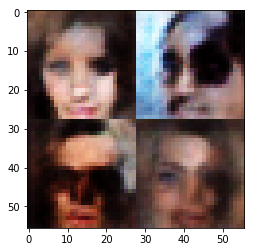

Epoch1/1.... Discrimiator loss :1.4747.. Generator loss :0.7941..
Epoch1/1.... Discrimiator loss :1.3032.. Generator loss :0.7860..
Epoch1/1.... Discrimiator loss :1.2687.. Generator loss :0.8789..
Epoch1/1.... Discrimiator loss :1.2587.. Generator loss :0.7934..


Epoch1/1.... Discrimiator loss :1.1993.. Generator loss :0.7967..
Epoch1/1.... Discrimiator loss :1.2678.. Generator loss :0.7838..
Epoch1/1.... Discrimiator loss :1.2437.. Generator loss :0.7822..
Epoch1/1.... Discrimiator loss :1.3120.. Generator loss :0.7714..


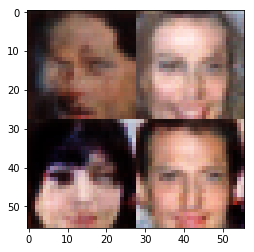

Epoch1/1.... Discrimiator loss :1.3728.. Generator loss :0.7680..
Epoch1/1.... Discrimiator loss :1.2305.. Generator loss :0.7887..
Epoch1/1.... Discrimiator loss :1.2920.. Generator loss :0.7859..
Epoch1/1.... Discrimiator loss :1.4039.. Generator loss :0.7364..


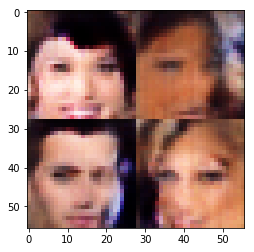

Epoch1/1.... Discrimiator loss :1.3819.. Generator loss :0.7561..
Epoch1/1.... Discrimiator loss :1.2816.. Generator loss :0.8412..
Epoch1/1.... Discrimiator loss :1.3772.. Generator loss :0.6933..
Epoch1/1.... Discrimiator loss :1.4908.. Generator loss :0.7386..


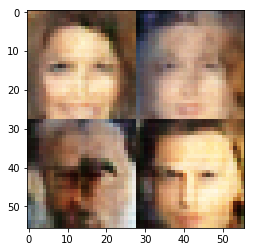

Epoch1/1.... Discrimiator loss :1.3597.. Generator loss :0.7556..
Epoch1/1.... Discrimiator loss :1.2879.. Generator loss :0.7920..
Epoch1/1.... Discrimiator loss :1.3382.. Generator loss :0.8526..
Epoch1/1.... Discrimiator loss :1.3923.. Generator loss :0.7419..


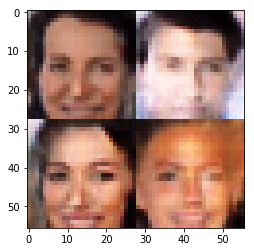

Epoch1/1.... Discrimiator loss :1.1946.. Generator loss :0.8408..
Epoch1/1.... Discrimiator loss :1.2108.. Generator loss :0.9386..
Epoch1/1.... Discrimiator loss :1.5085.. Generator loss :1.0788..
Epoch1/1.... Discrimiator loss :1.2082.. Generator loss :0.8449..


Epoch1/1.... Discrimiator loss :1.3639.. Generator loss :0.9402..


KeyboardInterrupt: 

In [39]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

(?, 2, 2, 512)
(?, 2, 2, 512)
Epoch1/1.... Discrimiator loss :0.7966.. Generator loss :1.3046..
Epoch1/1.... Discrimiator loss :1.1856.. Generator loss :0.8527..
Epoch1/1.... Discrimiator loss :0.9702.. Generator loss :0.9714..
Epoch1/1.... Discrimiator loss :1.6375.. Generator loss :1.5757..


Epoch1/1.... Discrimiator loss :1.2970.. Generator loss :0.9555..
Epoch1/1.... Discrimiator loss :1.1170.. Generator loss :1.0100..
Epoch1/1.... Discrimiator loss :1.0427.. Generator loss :1.0466..
Epoch1/1.... Discrimiator loss :1.0683.. Generator loss :1.2612..


Epoch1/1.... Discrimiator loss :1.1079.. Generator loss :0.9151..
Epoch1/1.... Discrimiator loss :1.2562.. Generator loss :1.1417..
Epoch1/1.... Discrimiator loss :0.9424.. Generator loss :1.7201..
Epoch1/1.... Discrimiator loss :0.9962.. Generator loss :1.2078..


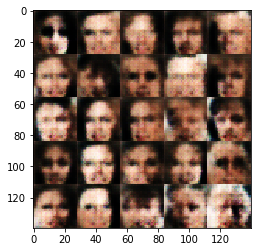

Epoch1/1.... Discrimiator loss :1.0604.. Generator loss :1.1270..
Epoch1/1.... Discrimiator loss :1.5421.. Generator loss :0.6740..
Epoch1/1.... Discrimiator loss :1.4753.. Generator loss :0.6703..
Epoch1/1.... Discrimiator loss :0.9674.. Generator loss :1.4681..


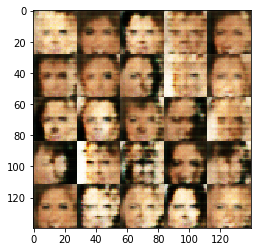

Epoch1/1.... Discrimiator loss :1.0223.. Generator loss :1.6613..
Epoch1/1.... Discrimiator loss :1.2202.. Generator loss :0.9976..
Epoch1/1.... Discrimiator loss :1.0735.. Generator loss :1.0590..
Epoch1/1.... Discrimiator loss :1.0201.. Generator loss :1.1232..


Epoch1/1.... Discrimiator loss :1.2230.. Generator loss :0.9220..
Epoch1/1.... Discrimiator loss :1.3767.. Generator loss :0.7348..
Epoch1/1.... Discrimiator loss :1.3198.. Generator loss :0.9761..
Epoch1/1.... Discrimiator loss :1.2472.. Generator loss :0.7866..


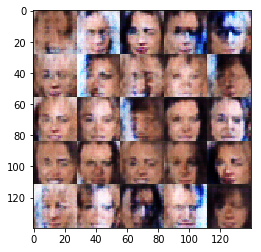

Epoch1/1.... Discrimiator loss :1.0410.. Generator loss :1.0287..
Epoch1/1.... Discrimiator loss :1.1833.. Generator loss :0.8405..
Epoch1/1.... Discrimiator loss :1.1677.. Generator loss :0.8118..
Epoch1/1.... Discrimiator loss :1.2678.. Generator loss :0.7909..


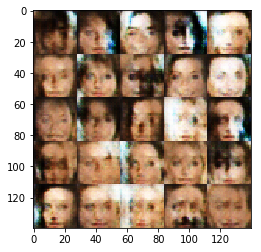

Epoch1/1.... Discrimiator loss :1.0899.. Generator loss :1.0711..
Epoch1/1.... Discrimiator loss :1.0600.. Generator loss :1.0606..
Epoch1/1.... Discrimiator loss :1.1409.. Generator loss :0.8676..
Epoch1/1.... Discrimiator loss :1.3793.. Generator loss :0.6340..


Epoch1/1.... Discrimiator loss :1.4126.. Generator loss :0.6354..
Epoch1/1.... Discrimiator loss :1.0975.. Generator loss :0.8865..
Epoch1/1.... Discrimiator loss :1.0169.. Generator loss :1.0733..
Epoch1/1.... Discrimiator loss :1.1546.. Generator loss :0.8510..


Epoch1/1.... Discrimiator loss :1.0969.. Generator loss :0.9053..
Epoch1/1.... Discrimiator loss :1.2580.. Generator loss :0.9954..
Epoch1/1.... Discrimiator loss :1.2237.. Generator loss :0.9101..
Epoch1/1.... Discrimiator loss :1.3430.. Generator loss :0.8361..


Epoch1/1.... Discrimiator loss :1.2507.. Generator loss :0.8452..
Epoch1/1.... Discrimiator loss :1.1162.. Generator loss :0.9475..
Epoch1/1.... Discrimiator loss :1.1176.. Generator loss :1.0933..
Epoch1/1.... Discrimiator loss :1.2180.. Generator loss :0.8232..


Epoch1/1.... Discrimiator loss :1.3227.. Generator loss :0.8263..
Epoch1/1.... Discrimiator loss :1.1425.. Generator loss :1.0591..
Epoch1/1.... Discrimiator loss :1.0909.. Generator loss :0.8785..
Epoch1/1.... Discrimiator loss :1.0448.. Generator loss :1.0850..


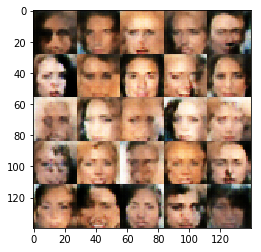

Epoch1/1.... Discrimiator loss :1.2045.. Generator loss :0.8790..
Epoch1/1.... Discrimiator loss :1.1705.. Generator loss :0.8211..
Epoch1/1.... Discrimiator loss :1.3582.. Generator loss :0.7765..
Epoch1/1.... Discrimiator loss :1.1051.. Generator loss :0.9703..


Epoch1/1.... Discrimiator loss :1.3802.. Generator loss :0.7600..
Epoch1/1.... Discrimiator loss :1.2600.. Generator loss :1.1121..
Epoch1/1.... Discrimiator loss :1.2109.. Generator loss :0.9978..
Epoch1/1.... Discrimiator loss :1.2226.. Generator loss :0.8678..


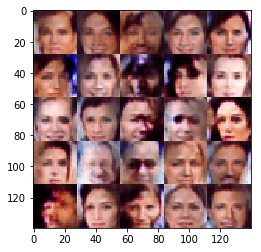

Epoch1/1.... Discrimiator loss :1.1461.. Generator loss :0.9045..
Epoch1/1.... Discrimiator loss :1.2912.. Generator loss :0.8832..
Epoch1/1.... Discrimiator loss :1.1979.. Generator loss :0.8999..
Epoch1/1.... Discrimiator loss :5.5556.. Generator loss :8.0858..


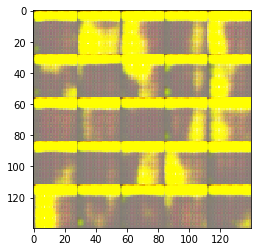

Epoch1/1.... Discrimiator loss :0.7534.. Generator loss :6.1387..
Epoch1/1.... Discrimiator loss :0.5725.. Generator loss :3.7731..
Epoch1/1.... Discrimiator loss :0.6189.. Generator loss :4.7068..
Epoch1/1.... Discrimiator loss :0.4577.. Generator loss :4.2468..


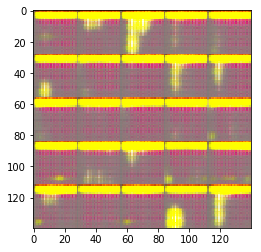

Epoch1/1.... Discrimiator loss :0.7660.. Generator loss :4.5814..
Epoch1/1.... Discrimiator loss :0.4897.. Generator loss :3.3300..
Epoch1/1.... Discrimiator loss :0.5431.. Generator loss :3.4437..


KeyboardInterrupt: 

In [42]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

12662
Epoch1/1.... Batch 50/12662.. Discrimiator loss :1.1201.. Generator loss :0.9896..
Epoch1/1.... Batch 100/12662.. Discrimiator loss :1.5101.. Generator loss :0.9296..
Epoch1/1.... Batch 150/12662.. Discrimiator loss :0.8553.. Generator loss :1.2505..
Epoch1/1.... Batch 200/12662.. Discrimiator loss :0.9104.. Generator loss :1.7049..


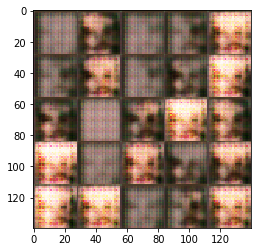

Epoch1/1.... Batch 250/12662.. Discrimiator loss :0.8729.. Generator loss :1.2631..
Epoch1/1.... Batch 300/12662.. Discrimiator loss :1.2345.. Generator loss :0.7409..
Epoch1/1.... Batch 350/12662.. Discrimiator loss :0.9788.. Generator loss :1.1180..
Epoch1/1.... Batch 400/12662.. Discrimiator loss :0.9363.. Generator loss :1.1215..


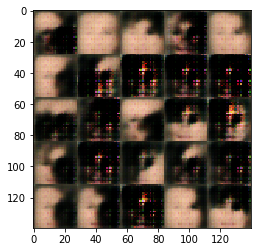

Epoch1/1.... Batch 450/12662.. Discrimiator loss :1.0743.. Generator loss :1.0982..
Epoch1/1.... Batch 500/12662.. Discrimiator loss :1.0111.. Generator loss :0.9292..
Epoch1/1.... Batch 550/12662.. Discrimiator loss :0.7554.. Generator loss :1.8535..
Epoch1/1.... Batch 600/12662.. Discrimiator loss :0.8203.. Generator loss :1.4280..


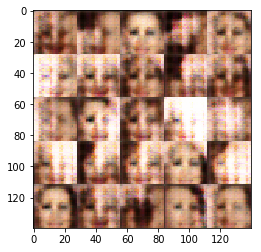

Epoch1/1.... Batch 650/12662.. Discrimiator loss :0.9581.. Generator loss :1.1098..
Epoch1/1.... Batch 700/12662.. Discrimiator loss :0.7285.. Generator loss :1.5730..
Epoch1/1.... Batch 750/12662.. Discrimiator loss :0.8429.. Generator loss :1.3077..
Epoch1/1.... Batch 800/12662.. Discrimiator loss :0.7343.. Generator loss :1.5718..


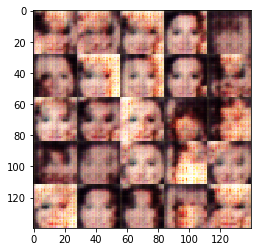

Epoch1/1.... Batch 850/12662.. Discrimiator loss :0.9979.. Generator loss :1.2734..
Epoch1/1.... Batch 900/12662.. Discrimiator loss :0.9198.. Generator loss :1.0472..
Epoch1/1.... Batch 950/12662.. Discrimiator loss :0.7584.. Generator loss :1.5960..
Epoch1/1.... Batch 1000/12662.. Discrimiator loss :0.9773.. Generator loss :1.1574..


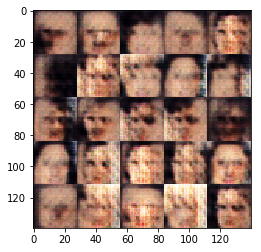

Epoch1/1.... Batch 1050/12662.. Discrimiator loss :0.7447.. Generator loss :1.9631..
Epoch1/1.... Batch 1100/12662.. Discrimiator loss :0.8917.. Generator loss :1.6350..
Epoch1/1.... Batch 1150/12662.. Discrimiator loss :0.8456.. Generator loss :1.2430..
Epoch1/1.... Batch 1200/12662.. Discrimiator loss :0.8163.. Generator loss :1.4771..


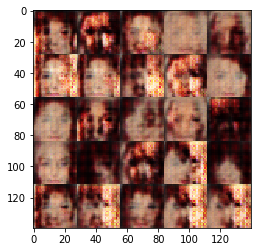

Epoch1/1.... Batch 1250/12662.. Discrimiator loss :0.8460.. Generator loss :1.2708..
Epoch1/1.... Batch 1300/12662.. Discrimiator loss :1.0293.. Generator loss :1.0131..
Epoch1/1.... Batch 1350/12662.. Discrimiator loss :0.5992.. Generator loss :2.2076..
Epoch1/1.... Batch 1400/12662.. Discrimiator loss :0.6967.. Generator loss :1.4392..


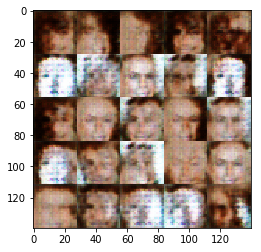

Epoch1/1.... Batch 1450/12662.. Discrimiator loss :0.9427.. Generator loss :1.3106..
Epoch1/1.... Batch 1500/12662.. Discrimiator loss :0.6341.. Generator loss :2.0275..
Epoch1/1.... Batch 1550/12662.. Discrimiator loss :0.7178.. Generator loss :1.7394..
Epoch1/1.... Batch 1600/12662.. Discrimiator loss :0.7530.. Generator loss :1.3642..


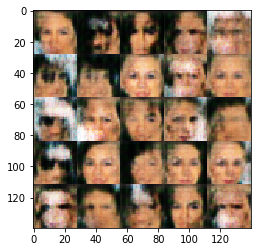

Epoch1/1.... Batch 1650/12662.. Discrimiator loss :1.0087.. Generator loss :1.0773..
Epoch1/1.... Batch 1700/12662.. Discrimiator loss :0.9382.. Generator loss :1.1932..
Epoch1/1.... Batch 1750/12662.. Discrimiator loss :0.8869.. Generator loss :1.1152..
Epoch1/1.... Batch 1800/12662.. Discrimiator loss :0.6634.. Generator loss :1.5652..


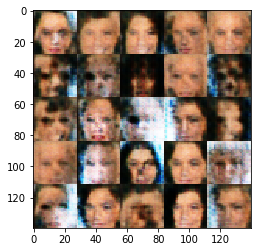

Epoch1/1.... Batch 1850/12662.. Discrimiator loss :0.6786.. Generator loss :1.4681..
Epoch1/1.... Batch 1900/12662.. Discrimiator loss :0.7081.. Generator loss :1.6649..
Epoch1/1.... Batch 1950/12662.. Discrimiator loss :0.7058.. Generator loss :1.4724..
Epoch1/1.... Batch 2000/12662.. Discrimiator loss :0.6845.. Generator loss :1.4792..


Epoch1/1.... Batch 2050/12662.. Discrimiator loss :0.8134.. Generator loss :1.6231..
Epoch1/1.... Batch 2100/12662.. Discrimiator loss :0.7084.. Generator loss :1.3846..
Epoch1/1.... Batch 2150/12662.. Discrimiator loss :0.9881.. Generator loss :1.0043..
Epoch1/1.... Batch 2200/12662.. Discrimiator loss :1.5235.. Generator loss :0.7021..


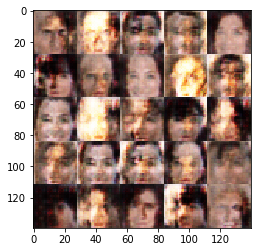

Epoch1/1.... Batch 2250/12662.. Discrimiator loss :0.6064.. Generator loss :1.7616..
Epoch1/1.... Batch 2300/12662.. Discrimiator loss :0.6037.. Generator loss :1.6848..
Epoch1/1.... Batch 2350/12662.. Discrimiator loss :1.1407.. Generator loss :2.4708..
Epoch1/1.... Batch 2400/12662.. Discrimiator loss :0.7393.. Generator loss :1.7678..


Epoch1/1.... Batch 2450/12662.. Discrimiator loss :0.9821.. Generator loss :1.0495..
Epoch1/1.... Batch 2500/12662.. Discrimiator loss :1.0466.. Generator loss :0.9178..
Epoch1/1.... Batch 2550/12662.. Discrimiator loss :0.6619.. Generator loss :1.8606..
Epoch1/1.... Batch 2600/12662.. Discrimiator loss :0.7372.. Generator loss :1.6180..


Epoch1/1.... Batch 2650/12662.. Discrimiator loss :0.5898.. Generator loss :1.8899..
Epoch1/1.... Batch 2700/12662.. Discrimiator loss :0.7519.. Generator loss :1.4504..
Epoch1/1.... Batch 2750/12662.. Discrimiator loss :0.7988.. Generator loss :1.2559..
Epoch1/1.... Batch 2800/12662.. Discrimiator loss :1.0655.. Generator loss :0.9711..


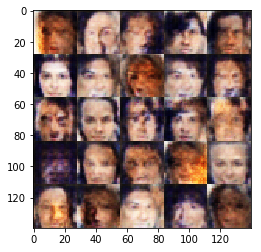

Epoch1/1.... Batch 2850/12662.. Discrimiator loss :0.7794.. Generator loss :1.4886..
Epoch1/1.... Batch 2900/12662.. Discrimiator loss :0.7965.. Generator loss :1.3905..
Epoch1/1.... Batch 2950/12662.. Discrimiator loss :0.7010.. Generator loss :1.5424..
Epoch1/1.... Batch 3000/12662.. Discrimiator loss :0.6881.. Generator loss :1.6403..


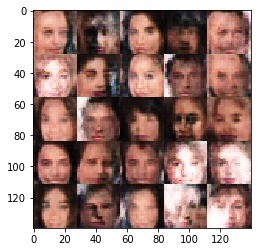

Epoch1/1.... Batch 3050/12662.. Discrimiator loss :0.6475.. Generator loss :1.6077..
Epoch1/1.... Batch 3100/12662.. Discrimiator loss :0.7112.. Generator loss :1.6484..
Epoch1/1.... Batch 3150/12662.. Discrimiator loss :0.8293.. Generator loss :1.1216..
Epoch1/1.... Batch 3200/12662.. Discrimiator loss :0.8225.. Generator loss :1.6315..


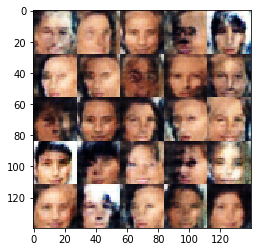

Epoch1/1.... Batch 3250/12662.. Discrimiator loss :0.8179.. Generator loss :1.2622..
Epoch1/1.... Batch 3300/12662.. Discrimiator loss :1.0499.. Generator loss :0.9214..
Epoch1/1.... Batch 3350/12662.. Discrimiator loss :0.9763.. Generator loss :1.0908..
Epoch1/1.... Batch 3400/12662.. Discrimiator loss :0.9777.. Generator loss :1.2462..


Epoch1/1.... Batch 3450/12662.. Discrimiator loss :0.7206.. Generator loss :1.4946..
Epoch1/1.... Batch 3500/12662.. Discrimiator loss :0.8813.. Generator loss :1.2979..
Epoch1/1.... Batch 3550/12662.. Discrimiator loss :0.8846.. Generator loss :1.0274..
Epoch1/1.... Batch 3600/12662.. Discrimiator loss :0.7737.. Generator loss :1.1783..


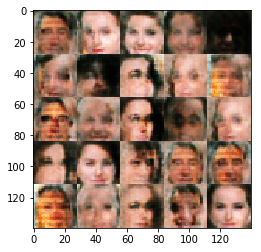

Epoch1/1.... Batch 3650/12662.. Discrimiator loss :1.1637.. Generator loss :0.6983..
Epoch1/1.... Batch 3700/12662.. Discrimiator loss :1.0221.. Generator loss :0.9638..
Epoch1/1.... Batch 3750/12662.. Discrimiator loss :0.8474.. Generator loss :1.2373..
Epoch1/1.... Batch 3800/12662.. Discrimiator loss :0.6432.. Generator loss :1.8231..


Epoch1/1.... Batch 3850/12662.. Discrimiator loss :0.6107.. Generator loss :1.7041..
Epoch1/1.... Batch 3900/12662.. Discrimiator loss :0.9310.. Generator loss :1.1394..
Epoch1/1.... Batch 3950/12662.. Discrimiator loss :1.0482.. Generator loss :0.8458..
Epoch1/1.... Batch 4000/12662.. Discrimiator loss :0.7186.. Generator loss :1.3859..


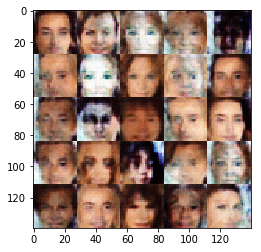

Epoch1/1.... Batch 4050/12662.. Discrimiator loss :0.6801.. Generator loss :1.6307..
Epoch1/1.... Batch 4100/12662.. Discrimiator loss :0.6464.. Generator loss :1.8921..
Epoch1/1.... Batch 4150/12662.. Discrimiator loss :0.7711.. Generator loss :1.8224..
Epoch1/1.... Batch 4200/12662.. Discrimiator loss :0.9681.. Generator loss :0.8532..


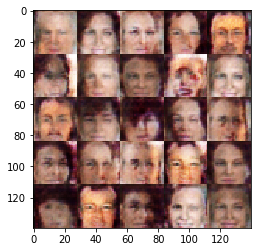

Epoch1/1.... Batch 4250/12662.. Discrimiator loss :0.6722.. Generator loss :1.5845..
Epoch1/1.... Batch 4300/12662.. Discrimiator loss :0.7385.. Generator loss :1.3433..
Epoch1/1.... Batch 4350/12662.. Discrimiator loss :0.8143.. Generator loss :1.1990..
Epoch1/1.... Batch 4400/12662.. Discrimiator loss :1.0313.. Generator loss :0.9746..


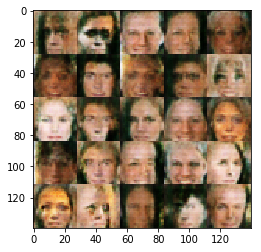

Epoch1/1.... Batch 4450/12662.. Discrimiator loss :0.8939.. Generator loss :1.2040..
Epoch1/1.... Batch 4500/12662.. Discrimiator loss :0.9423.. Generator loss :1.0998..
Epoch1/1.... Batch 4550/12662.. Discrimiator loss :0.9422.. Generator loss :1.7278..
Epoch1/1.... Batch 4600/12662.. Discrimiator loss :0.8904.. Generator loss :1.2479..


Epoch1/1.... Batch 4650/12662.. Discrimiator loss :1.1342.. Generator loss :0.7950..
Epoch1/1.... Batch 4700/12662.. Discrimiator loss :0.8856.. Generator loss :1.5836..
Epoch1/1.... Batch 4750/12662.. Discrimiator loss :0.7714.. Generator loss :1.2718..
Epoch1/1.... Batch 4800/12662.. Discrimiator loss :0.8870.. Generator loss :1.2863..


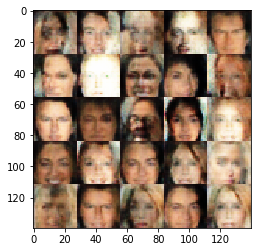

Epoch1/1.... Batch 4850/12662.. Discrimiator loss :0.6647.. Generator loss :1.5156..
Epoch1/1.... Batch 4900/12662.. Discrimiator loss :0.7199.. Generator loss :1.4597..
Epoch1/1.... Batch 4950/12662.. Discrimiator loss :1.0207.. Generator loss :0.9158..
Epoch1/1.... Batch 5000/12662.. Discrimiator loss :0.8960.. Generator loss :1.0557..


Epoch1/1.... Batch 5050/12662.. Discrimiator loss :0.8102.. Generator loss :1.2704..
Epoch1/1.... Batch 5100/12662.. Discrimiator loss :0.5795.. Generator loss :1.8454..
Epoch1/1.... Batch 5150/12662.. Discrimiator loss :0.7847.. Generator loss :1.5080..
Epoch1/1.... Batch 5200/12662.. Discrimiator loss :0.8232.. Generator loss :1.3402..


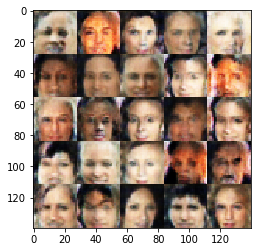

Epoch1/1.... Batch 5250/12662.. Discrimiator loss :1.0421.. Generator loss :1.0432..
Epoch1/1.... Batch 5300/12662.. Discrimiator loss :0.8120.. Generator loss :1.2980..
Epoch1/1.... Batch 5350/12662.. Discrimiator loss :0.9633.. Generator loss :1.8465..
Epoch1/1.... Batch 5400/12662.. Discrimiator loss :0.8033.. Generator loss :1.6730..


Epoch1/1.... Batch 5450/12662.. Discrimiator loss :1.0353.. Generator loss :0.8574..
Epoch1/1.... Batch 5500/12662.. Discrimiator loss :0.9206.. Generator loss :1.1191..
Epoch1/1.... Batch 5550/12662.. Discrimiator loss :0.8563.. Generator loss :1.4532..
Epoch1/1.... Batch 5600/12662.. Discrimiator loss :0.9130.. Generator loss :1.1338..


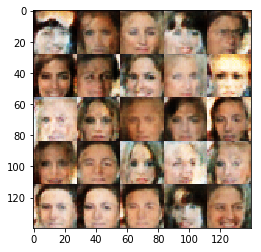

Epoch1/1.... Batch 5650/12662.. Discrimiator loss :0.8861.. Generator loss :1.2137..
Epoch1/1.... Batch 5700/12662.. Discrimiator loss :0.9874.. Generator loss :0.9956..
Epoch1/1.... Batch 5750/12662.. Discrimiator loss :0.8876.. Generator loss :1.9090..
Epoch1/1.... Batch 5800/12662.. Discrimiator loss :0.8265.. Generator loss :1.4044..


Epoch1/1.... Batch 5850/12662.. Discrimiator loss :1.0014.. Generator loss :0.9016..
Epoch1/1.... Batch 5900/12662.. Discrimiator loss :0.8925.. Generator loss :1.2625..
Epoch1/1.... Batch 5950/12662.. Discrimiator loss :1.1162.. Generator loss :0.9400..
Epoch1/1.... Batch 6000/12662.. Discrimiator loss :0.9844.. Generator loss :1.1762..


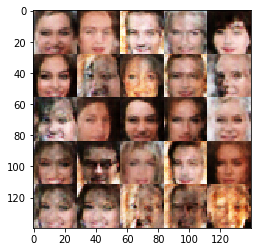

Epoch1/1.... Batch 6050/12662.. Discrimiator loss :0.9282.. Generator loss :1.0660..
Epoch1/1.... Batch 6100/12662.. Discrimiator loss :0.8456.. Generator loss :1.2174..
Epoch1/1.... Batch 6150/12662.. Discrimiator loss :0.9557.. Generator loss :1.1180..
Epoch1/1.... Batch 6200/12662.. Discrimiator loss :0.8801.. Generator loss :1.4239..


Epoch1/1.... Batch 6250/12662.. Discrimiator loss :1.0136.. Generator loss :0.9662..
Epoch1/1.... Batch 6300/12662.. Discrimiator loss :0.9740.. Generator loss :1.0281..
Epoch1/1.... Batch 6350/12662.. Discrimiator loss :0.9930.. Generator loss :1.0350..
Epoch1/1.... Batch 6400/12662.. Discrimiator loss :0.9564.. Generator loss :0.9927..


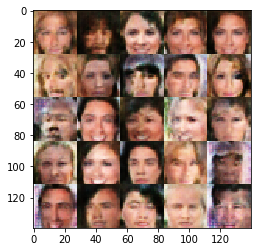

Epoch1/1.... Batch 6450/12662.. Discrimiator loss :0.7343.. Generator loss :1.3346..
Epoch1/1.... Batch 6500/12662.. Discrimiator loss :1.1916.. Generator loss :1.0440..
Epoch1/1.... Batch 6550/12662.. Discrimiator loss :0.8492.. Generator loss :1.4433..
Epoch1/1.... Batch 6600/12662.. Discrimiator loss :0.9409.. Generator loss :1.0407..


Epoch1/1.... Batch 6650/12662.. Discrimiator loss :1.1248.. Generator loss :0.9625..
Epoch1/1.... Batch 6700/12662.. Discrimiator loss :0.9514.. Generator loss :1.6397..
Epoch1/1.... Batch 6750/12662.. Discrimiator loss :1.0927.. Generator loss :1.0159..
Epoch1/1.... Batch 6800/12662.. Discrimiator loss :0.9160.. Generator loss :1.1329..


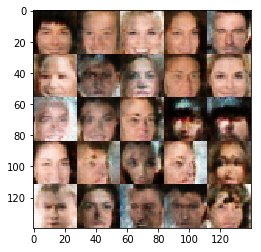

Epoch1/1.... Batch 6850/12662.. Discrimiator loss :0.9094.. Generator loss :1.1528..
Epoch1/1.... Batch 6900/12662.. Discrimiator loss :0.9575.. Generator loss :1.1407..
Epoch1/1.... Batch 6950/12662.. Discrimiator loss :0.9583.. Generator loss :1.0286..
Epoch1/1.... Batch 7000/12662.. Discrimiator loss :0.9303.. Generator loss :0.9778..


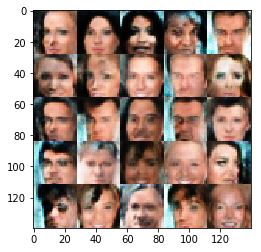

Epoch1/1.... Batch 7050/12662.. Discrimiator loss :0.9556.. Generator loss :1.0563..
Epoch1/1.... Batch 7100/12662.. Discrimiator loss :0.8962.. Generator loss :1.0861..
Epoch1/1.... Batch 7150/12662.. Discrimiator loss :0.9393.. Generator loss :1.0636..
Epoch1/1.... Batch 7200/12662.. Discrimiator loss :0.8713.. Generator loss :1.1053..


Epoch1/1.... Batch 7250/12662.. Discrimiator loss :1.0205.. Generator loss :0.8539..
Epoch1/1.... Batch 7300/12662.. Discrimiator loss :1.1232.. Generator loss :0.7741..
Epoch1/1.... Batch 7350/12662.. Discrimiator loss :1.2032.. Generator loss :0.7756..
Epoch1/1.... Batch 7400/12662.. Discrimiator loss :0.9335.. Generator loss :1.2975..


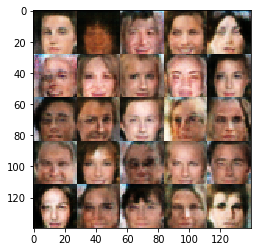

Epoch1/1.... Batch 7450/12662.. Discrimiator loss :0.8851.. Generator loss :1.1861..
Epoch1/1.... Batch 7500/12662.. Discrimiator loss :0.9774.. Generator loss :1.2842..
Epoch1/1.... Batch 7550/12662.. Discrimiator loss :0.8004.. Generator loss :1.2753..
Epoch1/1.... Batch 7600/12662.. Discrimiator loss :0.9020.. Generator loss :0.9777..


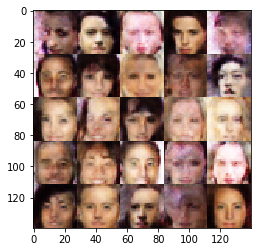

Epoch1/1.... Batch 7650/12662.. Discrimiator loss :0.7952.. Generator loss :1.9713..
Epoch1/1.... Batch 7700/12662.. Discrimiator loss :1.0156.. Generator loss :1.2338..
Epoch1/1.... Batch 7750/12662.. Discrimiator loss :0.8585.. Generator loss :1.4887..
Epoch1/1.... Batch 7800/12662.. Discrimiator loss :1.0550.. Generator loss :1.0489..


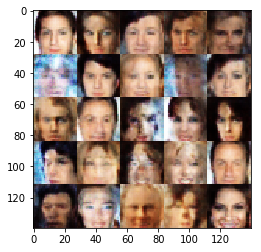

Epoch1/1.... Batch 7850/12662.. Discrimiator loss :1.0395.. Generator loss :1.0365..
Epoch1/1.... Batch 7900/12662.. Discrimiator loss :1.0475.. Generator loss :1.0232..
Epoch1/1.... Batch 7950/12662.. Discrimiator loss :1.0744.. Generator loss :0.9142..
Epoch1/1.... Batch 8000/12662.. Discrimiator loss :0.9611.. Generator loss :1.0285..


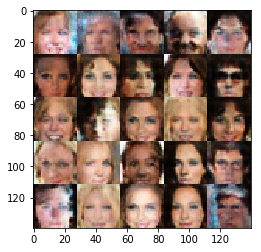

Epoch1/1.... Batch 8050/12662.. Discrimiator loss :1.0271.. Generator loss :0.9503..
Epoch1/1.... Batch 8100/12662.. Discrimiator loss :1.0785.. Generator loss :0.9662..
Epoch1/1.... Batch 8150/12662.. Discrimiator loss :0.9218.. Generator loss :1.3748..
Epoch1/1.... Batch 8200/12662.. Discrimiator loss :1.0672.. Generator loss :0.9397..


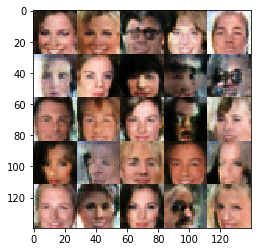

Epoch1/1.... Batch 8250/12662.. Discrimiator loss :1.0081.. Generator loss :0.9523..
Epoch1/1.... Batch 8300/12662.. Discrimiator loss :1.0300.. Generator loss :0.9277..
Epoch1/1.... Batch 8350/12662.. Discrimiator loss :1.0900.. Generator loss :1.5461..
Epoch1/1.... Batch 8400/12662.. Discrimiator loss :1.0683.. Generator loss :0.8910..


Epoch1/1.... Batch 8450/12662.. Discrimiator loss :1.0753.. Generator loss :0.9033..
Epoch1/1.... Batch 8500/12662.. Discrimiator loss :1.0043.. Generator loss :0.9283..
Epoch1/1.... Batch 8550/12662.. Discrimiator loss :1.0174.. Generator loss :0.9308..
Epoch1/1.... Batch 8600/12662.. Discrimiator loss :1.0047.. Generator loss :0.9847..


Epoch1/1.... Batch 8650/12662.. Discrimiator loss :1.0130.. Generator loss :1.0073..
Epoch1/1.... Batch 8700/12662.. Discrimiator loss :0.8342.. Generator loss :1.1942..
Epoch1/1.... Batch 8750/12662.. Discrimiator loss :1.0743.. Generator loss :0.9538..
Epoch1/1.... Batch 8800/12662.. Discrimiator loss :1.1780.. Generator loss :0.9429..


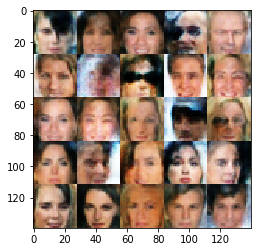

Epoch1/1.... Batch 8850/12662.. Discrimiator loss :0.9404.. Generator loss :1.0648..
Epoch1/1.... Batch 8900/12662.. Discrimiator loss :1.1491.. Generator loss :0.7786..
Epoch1/1.... Batch 8950/12662.. Discrimiator loss :1.0164.. Generator loss :0.9173..
Epoch1/1.... Batch 9000/12662.. Discrimiator loss :0.9460.. Generator loss :1.1782..


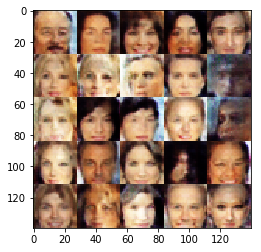

Epoch1/1.... Batch 9050/12662.. Discrimiator loss :0.9579.. Generator loss :0.9847..
Epoch1/1.... Batch 9100/12662.. Discrimiator loss :0.9174.. Generator loss :1.0673..
Epoch1/1.... Batch 9150/12662.. Discrimiator loss :1.0860.. Generator loss :1.1941..
Epoch1/1.... Batch 9200/12662.. Discrimiator loss :1.2170.. Generator loss :0.8344..


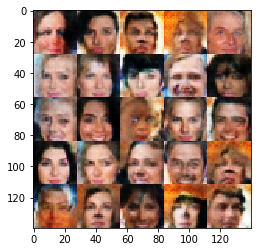

Epoch1/1.... Batch 9250/12662.. Discrimiator loss :1.0512.. Generator loss :0.9770..
Epoch1/1.... Batch 9300/12662.. Discrimiator loss :1.1600.. Generator loss :0.8642..
Epoch1/1.... Batch 9350/12662.. Discrimiator loss :1.0797.. Generator loss :0.9483..
Epoch1/1.... Batch 9400/12662.. Discrimiator loss :1.1596.. Generator loss :0.7253..


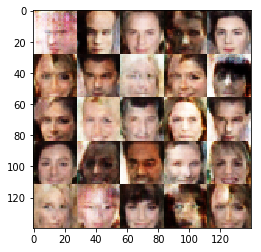

Epoch1/1.... Batch 9450/12662.. Discrimiator loss :1.1445.. Generator loss :0.8858..
Epoch1/1.... Batch 9500/12662.. Discrimiator loss :0.9805.. Generator loss :1.1266..
Epoch1/1.... Batch 9550/12662.. Discrimiator loss :1.1462.. Generator loss :0.9514..
Epoch1/1.... Batch 9600/12662.. Discrimiator loss :1.0847.. Generator loss :0.8535..


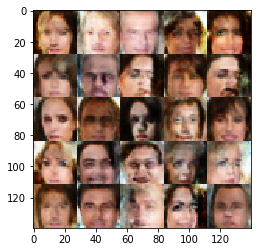

Epoch1/1.... Batch 9650/12662.. Discrimiator loss :0.8751.. Generator loss :1.1155..
Epoch1/1.... Batch 9700/12662.. Discrimiator loss :0.9234.. Generator loss :1.0991..
Epoch1/1.... Batch 9750/12662.. Discrimiator loss :1.0688.. Generator loss :0.9913..
Epoch1/1.... Batch 9800/12662.. Discrimiator loss :1.0331.. Generator loss :0.8866..


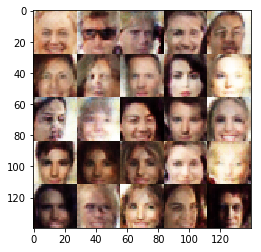

Epoch1/1.... Batch 9850/12662.. Discrimiator loss :1.0080.. Generator loss :1.0836..
Epoch1/1.... Batch 9900/12662.. Discrimiator loss :1.0296.. Generator loss :1.0664..
Epoch1/1.... Batch 9950/12662.. Discrimiator loss :1.1142.. Generator loss :0.8426..
Epoch1/1.... Batch 10000/12662.. Discrimiator loss :1.2951.. Generator loss :0.7022..


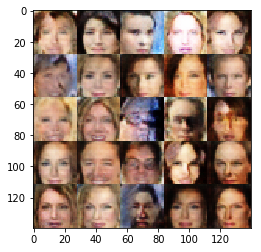

Epoch1/1.... Batch 10050/12662.. Discrimiator loss :1.1404.. Generator loss :1.0122..
Epoch1/1.... Batch 10100/12662.. Discrimiator loss :1.1085.. Generator loss :0.7877..
Epoch1/1.... Batch 10150/12662.. Discrimiator loss :1.0411.. Generator loss :1.0685..
Epoch1/1.... Batch 10200/12662.. Discrimiator loss :1.0191.. Generator loss :0.9506..


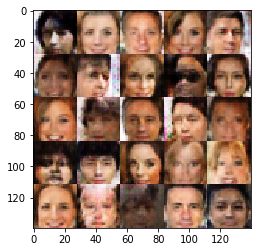

Epoch1/1.... Batch 10250/12662.. Discrimiator loss :1.0376.. Generator loss :1.1116..
Epoch1/1.... Batch 10300/12662.. Discrimiator loss :1.0927.. Generator loss :1.0612..
Epoch1/1.... Batch 10350/12662.. Discrimiator loss :0.9754.. Generator loss :1.0138..
Epoch1/1.... Batch 10400/12662.. Discrimiator loss :1.0749.. Generator loss :0.9559..


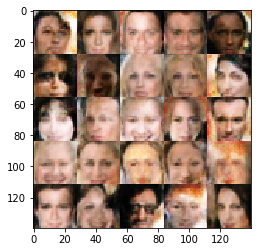

Epoch1/1.... Batch 10450/12662.. Discrimiator loss :1.0925.. Generator loss :1.0584..
Epoch1/1.... Batch 10500/12662.. Discrimiator loss :0.9770.. Generator loss :1.0028..
Epoch1/1.... Batch 10550/12662.. Discrimiator loss :0.9690.. Generator loss :0.9796..
Epoch1/1.... Batch 10600/12662.. Discrimiator loss :0.9806.. Generator loss :1.2740..


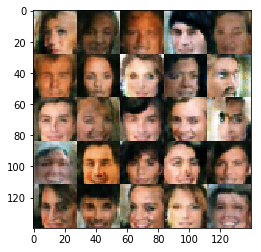

Epoch1/1.... Batch 10650/12662.. Discrimiator loss :0.9979.. Generator loss :0.9698..
Epoch1/1.... Batch 10700/12662.. Discrimiator loss :1.0636.. Generator loss :1.1042..
Epoch1/1.... Batch 10750/12662.. Discrimiator loss :1.0344.. Generator loss :1.0389..
Epoch1/1.... Batch 10800/12662.. Discrimiator loss :0.9866.. Generator loss :1.0219..


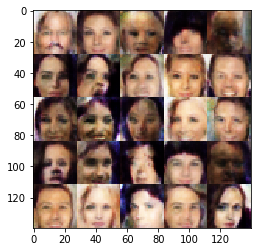

Epoch1/1.... Batch 10850/12662.. Discrimiator loss :1.0159.. Generator loss :1.0631..
Epoch1/1.... Batch 10900/12662.. Discrimiator loss :1.1097.. Generator loss :0.8981..
Epoch1/1.... Batch 10950/12662.. Discrimiator loss :1.1984.. Generator loss :0.8859..
Epoch1/1.... Batch 11000/12662.. Discrimiator loss :0.9656.. Generator loss :1.0854..


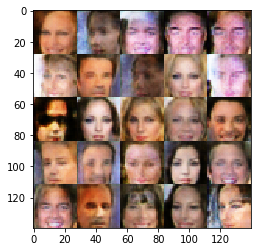

Epoch1/1.... Batch 11050/12662.. Discrimiator loss :1.1824.. Generator loss :0.9313..
Epoch1/1.... Batch 11100/12662.. Discrimiator loss :0.9906.. Generator loss :1.2111..
Epoch1/1.... Batch 11150/12662.. Discrimiator loss :0.9530.. Generator loss :1.2294..
Epoch1/1.... Batch 11200/12662.. Discrimiator loss :1.1052.. Generator loss :1.0139..


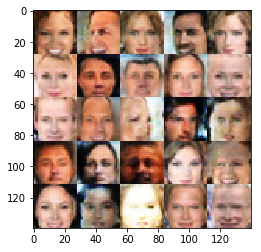

Epoch1/1.... Batch 11250/12662.. Discrimiator loss :1.1220.. Generator loss :0.8709..
Epoch1/1.... Batch 11300/12662.. Discrimiator loss :1.0040.. Generator loss :0.8771..
Epoch1/1.... Batch 11350/12662.. Discrimiator loss :1.0817.. Generator loss :0.9776..
Epoch1/1.... Batch 11400/12662.. Discrimiator loss :1.0520.. Generator loss :1.0198..


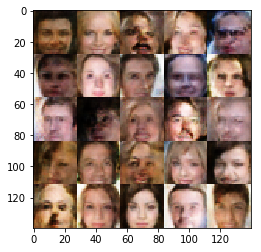

Epoch1/1.... Batch 11450/12662.. Discrimiator loss :1.0934.. Generator loss :0.9591..
Epoch1/1.... Batch 11500/12662.. Discrimiator loss :1.0052.. Generator loss :1.2115..
Epoch1/1.... Batch 11550/12662.. Discrimiator loss :1.0929.. Generator loss :0.9523..
Epoch1/1.... Batch 11600/12662.. Discrimiator loss :1.0531.. Generator loss :0.9179..


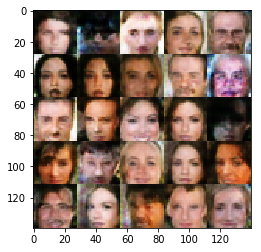

Epoch1/1.... Batch 11650/12662.. Discrimiator loss :1.0516.. Generator loss :1.0098..
Epoch1/1.... Batch 11700/12662.. Discrimiator loss :1.0266.. Generator loss :0.9828..
Epoch1/1.... Batch 11750/12662.. Discrimiator loss :1.2245.. Generator loss :0.7817..
Epoch1/1.... Batch 11800/12662.. Discrimiator loss :1.0696.. Generator loss :0.9597..


Epoch1/1.... Batch 11850/12662.. Discrimiator loss :1.1249.. Generator loss :0.8994..
Epoch1/1.... Batch 11900/12662.. Discrimiator loss :1.1020.. Generator loss :0.8384..
Epoch1/1.... Batch 11950/12662.. Discrimiator loss :1.1424.. Generator loss :1.0008..
Epoch1/1.... Batch 12000/12662.. Discrimiator loss :1.0029.. Generator loss :0.9763..


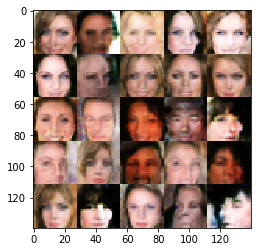

Epoch1/1.... Batch 12050/12662.. Discrimiator loss :1.1719.. Generator loss :0.9050..
Epoch1/1.... Batch 12100/12662.. Discrimiator loss :1.1891.. Generator loss :0.7520..
Epoch1/1.... Batch 12150/12662.. Discrimiator loss :1.1502.. Generator loss :0.8508..
Epoch1/1.... Batch 12200/12662.. Discrimiator loss :1.0567.. Generator loss :1.0109..


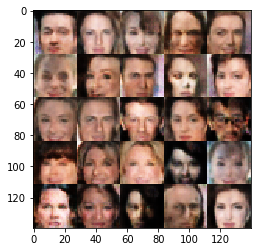

Epoch1/1.... Batch 12250/12662.. Discrimiator loss :1.1332.. Generator loss :0.8305..
Epoch1/1.... Batch 12300/12662.. Discrimiator loss :1.0978.. Generator loss :0.9057..
Epoch1/1.... Batch 12350/12662.. Discrimiator loss :1.0577.. Generator loss :0.9357..
Epoch1/1.... Batch 12400/12662.. Discrimiator loss :1.0863.. Generator loss :0.9076..


Epoch1/1.... Batch 12450/12662.. Discrimiator loss :1.0606.. Generator loss :0.8875..
Epoch1/1.... Batch 12500/12662.. Discrimiator loss :1.0893.. Generator loss :1.0727..
Epoch1/1.... Batch 12550/12662.. Discrimiator loss :1.0510.. Generator loss :0.9385..
Epoch1/1.... Batch 12600/12662.. Discrimiator loss :1.2118.. Generator loss :0.9436..


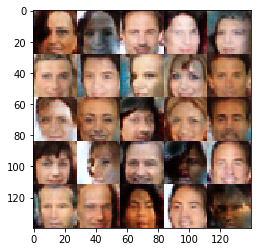

Epoch1/1.... Batch 12650/12662.. Discrimiator loss :0.9567.. Generator loss :1.1692..


In [71]:
batch_size = 16
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.